In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import tensorflow as tf
from xgboost import XGBRegressor
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM , Dropout

The first thing to optimize is the XGBoost algorithm, here we first tune the hyperparamters to obtain the best model that will provide us with the best performance. 

In [ ]:
from sklearn.model_selection import GridSearchCV
#Tuning Hyper-parameters for XGBoost
xgb_params = {
    "n_estimators" : [10,50,100,200,500],
    "learning_rate" : [0.001,0.01,0.1,0.05],
    "max_depth" : [3,5,7],
    "objective" : ["reg:squarederror"]
}
xgb_grid = GridSearchCV(XGBRegressor(),xgb_params,cv = 5,verbose = 1,
                        scoring = "neg_mean_squared_error")
xgb_grid.fit(X_train,y_train)

From the grid search, we determine the best parameters to be learning rate = 0.05, max_depth = 3 and n_estimators = 50.
We can see that the optimum number of estimators is relatively low likely to prevent overfitting.
After that we tune the lookback period to find the optimum lookback period for the XGBoost algorithm.

In [ ]:
df = pd.read_csv("Processed_Data.csv",index_col = 0)
train = df[:"2018-06"].values
test = df["2018-06":]
errors = {}

for lookback in range(9,100):
    max_lookback = lookback
    pred_interval = 8 
    input_len = max_lookback - pred_interval
    X_train =[]
    y_train = [] 
    for i in range(len(train)-max_lookback):
        X_train.append(train[i:i+max_lookback-pred_interval,2])
        y_train.append(train[i+max_lookback,2])
    X_train, y_train = np.array(X_train),np.array(y_train)
    inputs = df.iloc[len(df) - len(test) - max_lookback:,2]
    X_test = []
    y_test = []
    for i in range(len(inputs) - max_lookback):
        X_test.append(inputs[i:i+max_lookback-pred_interval])
        y_test.append(inputs[i+max_lookback])
    X_test = np.array(X_test)
    xgb = XGBRegressor(learning_rate= 0.05, max_depth= 3, n_estimators= 50,
                      objective = "reg:squarederror",verbosity= 0)
    xgb.fit(X_train,y_train)
    pred = xgb.predict(X_test)
    vis = pd.DataFrame([y_test,pred])
    vis = vis.T
    error = y_test - pred
    vis.columns = ["Actual","Predicted"]
    vis.index = test.index
    vis.plot()
    errors[max_lookback] = np.square(error).mean() #Mean Squared Error

From here we determine the optimum lookback period for XGBoost to be 55 Weeks. This is not surprising considering that the amount of time for an outbreak to occur and then recover is around 1 year. 

This is the final data preprocessing step in order to actually train the LSTM Model required for forecasting. For the model we have to predict dengue cases of T+8 time interval which is 8 weeks in advance. If we look at the data we see that the large cycles of dengue fluctuations around every 6 months and we use that as the lookback period. This means that to make a prediction for T+8, we have to use data from T-17 to T.

In [21]:
#Applying 1st Layer of XGBoost
df = pd.read_csv("Processed_Data.csv",index_col = 0)
train = df[:"2018-06"]
test = df["2018-06":]
max_lookback = 55
pred_interval = 8 
input_len = max_lookback - pred_interval
X_train =[]
y_train = [] 
for i in range(len(train)-max_lookback):

    X_train.append(train.iloc[i:i+max_lookback-pred_interval,2])
    y_train.append(train.iloc[i+max_lookback,2])
X_train, y_train = np.array(X_train),np.array(y_train)
inputs = df.iloc[len(df) - len(test) - max_lookback:,2]
X_test = []
y_test = []
for i in range(len(inputs) - max_lookback):
    X_test.append(inputs[i:i+max_lookback-pred_interval])
    y_test.append(inputs[i+max_lookback])
X_test = np.array(X_test)
xgb = XGBRegressor(learning_rate= 0.05, max_depth= 3, n_estimators= 50,
                  objective = "reg:squarederror",verbosity= 0)
xgb.fit(X_train,y_train)
pred = xgb.predict(X_train)
pred_test = xgb.predict(X_test)
df2 = pd.DataFrame(pred,index = train.iloc[max_lookback:].index,
                  columns = ["xgb"])
df2 = pd.concat([df2,train],axis =1,sort = True)
df2.loc[df2["xgb"].isna(),"xgb"] = df2[df2["xgb"].isna()]["dengue"]
df2.index = pd.to_datetime(df2.index)
sc2 = MinMaxScaler()
train1 = sc2.fit_transform(df2)

Now we implement a function to create multiple LSTMs with different architectures to find out which set of parameters is the most optimum for the model.

In [48]:
def adjust_model(max_lookback,layers,p,nodes,epochs = 250):
    max_lookback = max_lookback
    pred_interval = 8 
    input_len = max_lookback - pred_interval
    X_train =[]
    y_train = [] 
    for i in range(len(train1)-max_lookback):
        X_train.append(train1[i:i+input_len,:-1])
        y_train.append(train1[i+max_lookback,-1])
    X_train, y_train = np.array(X_train),np.array(y_train)
    model2 = Sequential()
    if layers == 1:
        model2.add(LSTM(units = nodes, return_sequences = False,
                        dropout = p, input_shape = (X_train.shape[1],3)))
    elif layers == 2:
        model2.add(LSTM(units = nodes, return_sequences = True,
                        dropout = p, input_shape = (X_train.shape[1],3)))
        model2.add(LSTM(units = nodes,dropout = p))
    else:
        model2.add(LSTM(units = nodes, return_sequences = True,
                        dropout = p, input_shape = (X_train.shape[1],3)))
        for i in range(layers-2):
            model2.add(LSTM(units = nodes, return_sequences = True,dropout = p))
        model2.add(LSTM(units = nodes,dropout = p))
    model2.add(Dense(1)) # No Activation because it is a regressor - you dont want your output to between 0 and 1
    model2.compile(optimizer = "rmsprop",loss = "mean_squared_error")
    model2.fit(X_train,y_train,epochs =epochs,batch_size=32,workers = 10,max_queue_size = 100)
    return model2

In [23]:
i = 1
params = {}
for a in [45,48,50,55,60]:
    for b in [3,4]:
        for c in [0,0.1,0.2]:
            for d in [10,20,30]:
                params[str(i)+" Pass"] = {"max_lookback" : a,
                                          "layers" : b,
                                          "p" : c,
                                          "nodes": d}
                i += 1

In [38]:
param_results = {}
for passes, param in params.items():
    print("===========",passes,"===========")
    model2 = adjust_model(**param)
    df3 = pd.DataFrame(pred_test,index = test.index,
                  columns = ["xgb"])
    df3 = pd.concat([test,df3],axis = 1)
    cols = df3.columns.to_list()
    cols = [cols[-1]] + cols[:-1]
    df3 = df3[cols]
    df3.index = pd.to_datetime(df3.index)
    df2 = pd.concat([df2,df3],axis = 0, sort = True)
    df2 = df2[cols]
    input_len = param["max_lookback"] - 8
    inputs = df2.iloc[len(df2) - len(test) - input_len:]
    inputs = sc2.transform(inputs)
    X_test = []
    for i in range(len(inputs) - input_len):
        X_test.append(inputs[i:i+input_len,:-1])
    X_test= np.array(X_test)
    pred = model2.predict(X_test)
    actual = test["dengue"].values
    pred = np.concatenate([np.zeros((pred.shape[0],3)),pred],axis = 1)
    results  = sc2.inverse_transform(pred)
    error = actual - results[:,-1]
    vis = pd.DataFrame([actual,results[:,-1]])
    vis = vis.T
    vis.columns = ["Actual","Predicted"]
    vis.index = test.index
    vis.index = pd.to_datetime(vis.index)
    vis.plot()
    plt.savefig("plots/"+passes+".png")
    plt.close()
    param_results[passes] = np.square(error).mean() #Mean Squared Error
    if np.square(error).mean() < 10000:
        model2.save("models/"+passes+".h5") #Saving models that have optimum results

=========== 4 Pass ===========
Train on 290 samples
Epoch 1/250
290/290 [==============================] - 5s 17ms/sample - loss: 0.0602
Epoch 2/250
290/290 [==============================] - 0s 512us/sample - loss: 0.0447
Epoch 3/250
290/290 [==============================] - 0s 530us/sample - loss: 0.0420
Epoch 4/250
290/290 [==============================] - 0s 519us/sample - loss: 0.0408
Epoch 5/250
290/290 [==============================] - 0s 513us/sample - loss: 0.0401
Epoch 6/250
290/290 [==============================] - 0s 519us/sample - loss: 0.0385
Epoch 7/250
290/290 [==============================] - 0s 529us/sample - loss: 0.0370
Epoch 8/250
290/290 [==============================] - 0s 520us/sample - loss: 0.0366
Epoch 9/250
290/290 [==============================] - 0s 517us/sample - loss: 0.0361
Epoch 10/250
290/290 [==============================] - 0s 538us/sample - loss: 0.0341
Epoch 11/250
290/290 [==============================] - 0s 588us/sample - loss: 0.0345
E

290/290 [==============================] - 0s 342us/sample - loss: 0.0083
Epoch 188/250
290/290 [==============================] - 0s 318us/sample - loss: 0.0079
Epoch 189/250
290/290 [==============================] - 0s 337us/sample - loss: 0.0079
Epoch 190/250
290/290 [==============================] - 0s 330us/sample - loss: 0.0087
Epoch 191/250
290/290 [==============================] - 0s 327us/sample - loss: 0.0080
Epoch 192/250
290/290 [==============================] - 0s 373us/sample - loss: 0.0075
Epoch 193/250
290/290 [==============================] - 0s 475us/sample - loss: 0.0076
Epoch 194/250
290/290 [==============================] - 0s 336us/sample - loss: 0.0082
Epoch 195/250
290/290 [==============================] - 0s 327us/sample - loss: 0.0083
Epoch 196/250
290/290 [==============================] - 0s 337us/sample - loss: 0.0079
Epoch 197/250
290/290 [==============================] - 0s 341us/sample - loss: 0.0065
Epoch 198/250
290/290 [=======================

290/290 [==============================] - 0s 304us/sample - loss: 0.0231
Epoch 31/250
290/290 [==============================] - 0s 309us/sample - loss: 0.0202
Epoch 32/250
290/290 [==============================] - 0s 327us/sample - loss: 0.0213
Epoch 33/250
290/290 [==============================] - 0s 307us/sample - loss: 0.0218
Epoch 34/250
290/290 [==============================] - 0s 320us/sample - loss: 0.0193
Epoch 35/250
290/290 [==============================] - 0s 318us/sample - loss: 0.0202
Epoch 36/250
290/290 [==============================] - 0s 312us/sample - loss: 0.0199
Epoch 37/250
290/290 [==============================] - 0s 313us/sample - loss: 0.0171
Epoch 38/250
290/290 [==============================] - 0s 306us/sample - loss: 0.0183
Epoch 39/250
290/290 [==============================] - 0s 318us/sample - loss: 0.0207
Epoch 40/250
290/290 [==============================] - 0s 303us/sample - loss: 0.0145
Epoch 41/250
290/290 [==============================] - 

290/290 [==============================] - 0s 316us/sample - loss: 0.0068
Epoch 125/250
290/290 [==============================] - 0s 335us/sample - loss: 0.0070
Epoch 126/250
290/290 [==============================] - 0s 321us/sample - loss: 0.0099
Epoch 127/250
290/290 [==============================] - 0s 312us/sample - loss: 0.0050
Epoch 128/250
290/290 [==============================] - 0s 321us/sample - loss: 0.0061
Epoch 129/250
290/290 [==============================] - 0s 425us/sample - loss: 0.0060
Epoch 130/250
290/290 [==============================] - 0s 354us/sample - loss: 0.0054
Epoch 131/250
290/290 [==============================] - 0s 344us/sample - loss: 0.0061
Epoch 132/250
290/290 [==============================] - 0s 337us/sample - loss: 0.0074
Epoch 133/250
290/290 [==============================] - 0s 305us/sample - loss: 0.0056
Epoch 134/250
290/290 [==============================] - 0s 298us/sample - loss: 0.0063
Epoch 135/250
290/290 [=======================

290/290 [==============================] - 0s 348us/sample - loss: 0.0083
Epoch 61/250
290/290 [==============================] - 0s 308us/sample - loss: 0.0114
Epoch 62/250
290/290 [==============================] - 0s 317us/sample - loss: 0.0081
Epoch 63/250
290/290 [==============================] - 0s 315us/sample - loss: 0.0075
Epoch 64/250
290/290 [==============================] - 0s 328us/sample - loss: 0.0121
Epoch 65/250
290/290 [==============================] - 0s 337us/sample - loss: 0.0065
Epoch 66/250
290/290 [==============================] - 0s 484us/sample - loss: 0.0082
Epoch 67/250
290/290 [==============================] - 0s 438us/sample - loss: 0.0123
Epoch 68/250
290/290 [==============================] - 0s 303us/sample - loss: 0.0070
Epoch 69/250
290/290 [==============================] - 0s 307us/sample - loss: 0.0074
Epoch 70/250
290/290 [==============================] - 0s 342us/sample - loss: 0.0098
Epoch 71/250
290/290 [==============================] - 

290/290 [==============================] - 0s 346us/sample - loss: 0.0051
Epoch 247/250
290/290 [==============================] - 0s 338us/sample - loss: 0.0025
Epoch 248/250
290/290 [==============================] - 0s 329us/sample - loss: 0.0036
Epoch 249/250
290/290 [==============================] - 0s 321us/sample - loss: 0.0031
Epoch 250/250
290/290 [==============================] - 0s 324us/sample - loss: 0.0033
=========== 7 Pass ===========
Train on 290 samples
Epoch 1/250
290/290 [==============================] - 4s 15ms/sample - loss: 0.0480
Epoch 2/250
290/290 [==============================] - 0s 316us/sample - loss: 0.0404
Epoch 3/250
290/290 [==============================] - 0s 303us/sample - loss: 0.0387
Epoch 4/250
290/290 [==============================] - 0s 303us/sample - loss: 0.0381
Epoch 5/250
290/290 [==============================] - 0s 413us/sample - loss: 0.0367
Epoch 6/250
290/290 [==============================] - 0s 481us/sample - loss: 0.0367
Epoch 7

290/290 [==============================] - 0s 336us/sample - loss: 0.0125
Epoch 183/250
290/290 [==============================] - 0s 317us/sample - loss: 0.0079
Epoch 184/250
290/290 [==============================] - 0s 316us/sample - loss: 0.0095
Epoch 185/250
290/290 [==============================] - 0s 326us/sample - loss: 0.0102
Epoch 186/250
290/290 [==============================] - 0s 471us/sample - loss: 0.0085
Epoch 187/250
290/290 [==============================] - 0s 434us/sample - loss: 0.0087
Epoch 188/250
290/290 [==============================] - 0s 323us/sample - loss: 0.0086
Epoch 189/250
290/290 [==============================] - 0s 301us/sample - loss: 0.0092
Epoch 190/250
290/290 [==============================] - 0s 332us/sample - loss: 0.0084
Epoch 191/250
290/290 [==============================] - 0s 309us/sample - loss: 0.0084
Epoch 192/250
290/290 [==============================] - 0s 377us/sample - loss: 0.0077
Epoch 193/250
290/290 [=======================

290/290 [==============================] - 0s 306us/sample - loss: 0.0255
Epoch 26/250
290/290 [==============================] - 0s 313us/sample - loss: 0.0261
Epoch 27/250
290/290 [==============================] - 0s 306us/sample - loss: 0.0237
Epoch 28/250
290/290 [==============================] - 0s 306us/sample - loss: 0.0250
Epoch 29/250
290/290 [==============================] - 0s 299us/sample - loss: 0.0260
Epoch 30/250
290/290 [==============================] - 0s 304us/sample - loss: 0.0236
Epoch 31/250
290/290 [==============================] - 0s 309us/sample - loss: 0.0256
Epoch 32/250
290/290 [==============================] - 0s 299us/sample - loss: 0.0249
Epoch 33/250
290/290 [==============================] - 0s 297us/sample - loss: 0.0228
Epoch 34/250
290/290 [==============================] - 0s 301us/sample - loss: 0.0235
Epoch 35/250
290/290 [==============================] - 0s 300us/sample - loss: 0.0219
Epoch 36/250
290/290 [==============================] - 

290/290 [==============================] - 0s 308us/sample - loss: 0.0079
Epoch 120/250
290/290 [==============================] - 0s 315us/sample - loss: 0.0095
Epoch 121/250
290/290 [==============================] - 0s 340us/sample - loss: 0.0078
Epoch 122/250
290/290 [==============================] - 0s 343us/sample - loss: 0.0104
Epoch 123/250
290/290 [==============================] - 0s 496us/sample - loss: 0.0080
Epoch 124/250
290/290 [==============================] - 0s 394us/sample - loss: 0.0097
Epoch 125/250
290/290 [==============================] - 0s 299us/sample - loss: 0.0071
Epoch 126/250
290/290 [==============================] - 0s 309us/sample - loss: 0.0081
Epoch 127/250
290/290 [==============================] - 0s 341us/sample - loss: 0.0084
Epoch 128/250
290/290 [==============================] - 0s 313us/sample - loss: 0.0084
Epoch 129/250
290/290 [==============================] - 0s 313us/sample - loss: 0.0074
Epoch 130/250
290/290 [=======================

290/290 [==============================] - 0s 310us/sample - loss: 0.0130
Epoch 56/250
290/290 [==============================] - 0s 308us/sample - loss: 0.0145
Epoch 57/250
290/290 [==============================] - 0s 306us/sample - loss: 0.0128
Epoch 58/250
290/290 [==============================] - 0s 310us/sample - loss: 0.0099
Epoch 59/250
290/290 [==============================] - 0s 304us/sample - loss: 0.0129
Epoch 60/250
290/290 [==============================] - 0s 305us/sample - loss: 0.0117
Epoch 61/250
290/290 [==============================] - 0s 304us/sample - loss: 0.0132
Epoch 62/250
290/290 [==============================] - 0s 310us/sample - loss: 0.0114
Epoch 63/250
290/290 [==============================] - 0s 304us/sample - loss: 0.0142
Epoch 64/250
290/290 [==============================] - 0s 307us/sample - loss: 0.0110
Epoch 65/250
290/290 [==============================] - 0s 308us/sample - loss: 0.0105
Epoch 66/250
290/290 [==============================] - 

290/290 [==============================] - 0s 308us/sample - loss: 0.0051
Epoch 242/250
290/290 [==============================] - 0s 440us/sample - loss: 0.0059
Epoch 243/250
290/290 [==============================] - 0s 543us/sample - loss: 0.0052
Epoch 244/250
290/290 [==============================] - 0s 321us/sample - loss: 0.0051
Epoch 245/250
290/290 [==============================] - 0s 320us/sample - loss: 0.0056
Epoch 246/250
290/290 [==============================] - 0s 340us/sample - loss: 0.0036
Epoch 247/250
290/290 [==============================] - 0s 372us/sample - loss: 0.0053
Epoch 248/250
290/290 [==============================] - 0s 512us/sample - loss: 0.0045
Epoch 249/250
290/290 [==============================] - 0s 344us/sample - loss: 0.0047
Epoch 250/250
290/290 [==============================] - 0s 316us/sample - loss: 0.0050
=========== 10 Pass ===========
Train on 290 samples
Epoch 1/250
290/290 [==============================] - 6s 20ms/sample - loss: 0.0

290/290 [==============================] - 0s 368us/sample - loss: 0.0048
Epoch 178/250
290/290 [==============================] - 0s 358us/sample - loss: 0.0045
Epoch 179/250
290/290 [==============================] - 0s 366us/sample - loss: 0.0071
Epoch 180/250
290/290 [==============================] - 0s 365us/sample - loss: 0.0037
Epoch 181/250
290/290 [==============================] - 0s 370us/sample - loss: 0.0046
Epoch 182/250
290/290 [==============================] - 0s 365us/sample - loss: 0.0060
Epoch 183/250
290/290 [==============================] - 0s 365us/sample - loss: 0.0048
Epoch 184/250
290/290 [==============================] - 0s 386us/sample - loss: 0.0044
Epoch 185/250
290/290 [==============================] - 0s 361us/sample - loss: 0.0050
Epoch 186/250
290/290 [==============================] - 0s 371us/sample - loss: 0.0037
Epoch 187/250
290/290 [==============================] - 0s 368us/sample - loss: 0.0047
Epoch 188/250
290/290 [=======================

Epoch 20/250
290/290 [==============================] - 0s 394us/sample - loss: 0.0228
Epoch 21/250
290/290 [==============================] - 0s 375us/sample - loss: 0.0258
Epoch 22/250
290/290 [==============================] - 0s 385us/sample - loss: 0.0223
Epoch 23/250
290/290 [==============================] - 0s 352us/sample - loss: 0.0258
Epoch 24/250
290/290 [==============================] - 0s 359us/sample - loss: 0.0209
Epoch 25/250
290/290 [==============================] - 0s 355us/sample - loss: 0.0192
Epoch 26/250
290/290 [==============================] - 0s 371us/sample - loss: 0.0235
Epoch 27/250
290/290 [==============================] - 0s 448us/sample - loss: 0.0160
Epoch 28/250
290/290 [==============================] - 0s 377us/sample - loss: 0.0185
Epoch 29/250
290/290 [==============================] - 0s 408us/sample - loss: 0.0172
Epoch 30/250
290/290 [==============================] - 0s 382us/sample - loss: 0.0159
Epoch 31/250
290/290 [=====================

290/290 [==============================] - 0s 434us/sample - loss: 0.0038
Epoch 115/250
290/290 [==============================] - 0s 382us/sample - loss: 0.0075
Epoch 116/250
290/290 [==============================] - 0s 402us/sample - loss: 0.0029
Epoch 117/250
290/290 [==============================] - 0s 413us/sample - loss: 0.0040
Epoch 118/250
290/290 [==============================] - 0s 420us/sample - loss: 0.0056
Epoch 119/250
290/290 [==============================] - 0s 399us/sample - loss: 0.0050
Epoch 120/250
290/290 [==============================] - 0s 466us/sample - loss: 0.0039
Epoch 121/250
290/290 [==============================] - 0s 479us/sample - loss: 0.0039
Epoch 122/250
290/290 [==============================] - 0s 399us/sample - loss: 0.0039
Epoch 123/250
290/290 [==============================] - 0s 437us/sample - loss: 0.0051
Epoch 124/250
290/290 [==============================] - 0s 484us/sample - loss: 0.0042
Epoch 125/250
290/290 [=======================

290/290 [==============================] - 0s 434us/sample - loss: 0.0095
Epoch 51/250
290/290 [==============================] - 0s 420us/sample - loss: 0.0094
Epoch 52/250
290/290 [==============================] - 0s 440us/sample - loss: 0.0094
Epoch 53/250
290/290 [==============================] - 0s 416us/sample - loss: 0.0058
Epoch 54/250
290/290 [==============================] - 0s 428us/sample - loss: 0.0092
Epoch 55/250
290/290 [==============================] - 0s 435us/sample - loss: 0.0074
Epoch 56/250
290/290 [==============================] - 0s 489us/sample - loss: 0.0116
Epoch 57/250
290/290 [==============================] - 0s 423us/sample - loss: 0.0150
Epoch 58/250
290/290 [==============================] - 0s 395us/sample - loss: 0.0055
Epoch 59/250
290/290 [==============================] - 0s 407us/sample - loss: 0.0095
Epoch 60/250
290/290 [==============================] - 0s 432us/sample - loss: 0.0062
Epoch 61/250
290/290 [==============================] - 

290/290 [==============================] - 0s 392us/sample - loss: 0.0025
Epoch 237/250
290/290 [==============================] - 0s 423us/sample - loss: 0.0024
Epoch 238/250
290/290 [==============================] - 0s 402us/sample - loss: 0.0019
Epoch 239/250
290/290 [==============================] - 0s 418us/sample - loss: 0.0023
Epoch 240/250
290/290 [==============================] - 0s 389us/sample - loss: 0.0022
Epoch 241/250
290/290 [==============================] - 0s 382us/sample - loss: 0.0024
Epoch 242/250
290/290 [==============================] - 0s 385us/sample - loss: 0.0023
Epoch 243/250
290/290 [==============================] - 0s 403us/sample - loss: 0.0021
Epoch 244/250
290/290 [==============================] - 0s 430us/sample - loss: 0.0022
Epoch 245/250
290/290 [==============================] - 0s 440us/sample - loss: 0.0032
Epoch 246/250
290/290 [==============================] - 0s 420us/sample - loss: 0.0021
Epoch 247/250
290/290 [=======================

290/290 [==============================] - 0s 396us/sample - loss: 0.0083
Epoch 173/250
290/290 [==============================] - 0s 395us/sample - loss: 0.0067
Epoch 174/250
290/290 [==============================] - 0s 370us/sample - loss: 0.0062
Epoch 175/250
290/290 [==============================] - 0s 371us/sample - loss: 0.0093
Epoch 176/250
290/290 [==============================] - 0s 372us/sample - loss: 0.0077
Epoch 177/250
290/290 [==============================] - 0s 399us/sample - loss: 0.0083s - loss: 0.006
Epoch 178/250
290/290 [==============================] - 0s 622us/sample - loss: 0.0081
Epoch 179/250
290/290 [==============================] - 0s 792us/sample - loss: 0.0069
Epoch 180/250
290/290 [==============================] - 0s 617us/sample - loss: 0.0074
Epoch 181/250
290/290 [==============================] - 0s 672us/sample - loss: 0.0079
Epoch 182/250
290/290 [==============================] - 0s 524us/sample - loss: 0.0063
Epoch 183/250
290/290 [========

290/290 [==============================] - 0s 364us/sample - loss: 0.0079
Epoch 109/250
290/290 [==============================] - 0s 369us/sample - loss: 0.0073
Epoch 110/250
290/290 [==============================] - 0s 375us/sample - loss: 0.0071
Epoch 111/250
290/290 [==============================] - 0s 417us/sample - loss: 0.0065
Epoch 112/250
290/290 [==============================] - 0s 409us/sample - loss: 0.0076
Epoch 113/250
290/290 [==============================] - 0s 376us/sample - loss: 0.0075
Epoch 114/250
290/290 [==============================] - 0s 378us/sample - loss: 0.0096
Epoch 115/250
290/290 [==============================] - 0s 378us/sample - loss: 0.0071
Epoch 116/250
290/290 [==============================] - 0s 401us/sample - loss: 0.0066
Epoch 117/250
290/290 [==============================] - 0s 388us/sample - loss: 0.0074
Epoch 118/250
290/290 [==============================] - 0s 404us/sample - loss: 0.0074
Epoch 119/250
290/290 [=======================

Epoch 201/250
290/290 [==============================] - 0s 406us/sample - loss: 0.0049
Epoch 202/250
290/290 [==============================] - 0s 395us/sample - loss: 0.0050
Epoch 203/250
290/290 [==============================] - 0s 391us/sample - loss: 0.0037
Epoch 204/250
290/290 [==============================] - 0s 395us/sample - loss: 0.0040
Epoch 205/250
290/290 [==============================] - 0s 402us/sample - loss: 0.0060
Epoch 206/250
290/290 [==============================] - 0s 395us/sample - loss: 0.0037
Epoch 207/250
290/290 [==============================] - 0s 397us/sample - loss: 0.0044
Epoch 208/250
290/290 [==============================] - 0s 381us/sample - loss: 0.0053
Epoch 209/250
290/290 [==============================] - 0s 407us/sample - loss: 0.0042
Epoch 210/250
290/290 [==============================] - 0s 402us/sample - loss: 0.0043
Epoch 211/250
290/290 [==============================] - 0s 393us/sample - loss: 0.0050
Epoch 212/250
290/290 [=========

290/290 [==============================] - 0s 433us/sample - loss: 0.0176
Epoch 45/250
290/290 [==============================] - 0s 640us/sample - loss: 0.0091
Epoch 46/250
290/290 [==============================] - 0s 501us/sample - loss: 0.0089
Epoch 47/250
290/290 [==============================] - 0s 399us/sample - loss: 0.0121
Epoch 48/250
290/290 [==============================] - 0s 395us/sample - loss: 0.0106
Epoch 49/250
290/290 [==============================] - 0s 629us/sample - loss: 0.0158
Epoch 50/250
290/290 [==============================] - 0s 526us/sample - loss: 0.0102
Epoch 51/250
290/290 [==============================] - 0s 398us/sample - loss: 0.0089
Epoch 52/250
290/290 [==============================] - 0s 447us/sample - loss: 0.0121
Epoch 53/250
290/290 [==============================] - 0s 660us/sample - loss: 0.0112
Epoch 54/250
290/290 [==============================] - 0s 405us/sample - loss: 0.0084
Epoch 55/250
290/290 [==============================] - 

290/290 [==============================] - 0s 518us/sample - loss: 0.0032
Epoch 231/250
290/290 [==============================] - 0s 392us/sample - loss: 0.0041
Epoch 232/250
290/290 [==============================] - 0s 454us/sample - loss: 0.0026
Epoch 233/250
290/290 [==============================] - 0s 500us/sample - loss: 0.0038
Epoch 234/250
290/290 [==============================] - 0s 381us/sample - loss: 0.0034
Epoch 235/250
290/290 [==============================] - 0s 389us/sample - loss: 0.0034
Epoch 236/250
290/290 [==============================] - 0s 386us/sample - loss: 0.0037
Epoch 237/250
290/290 [==============================] - 0s 384us/sample - loss: 0.0030
Epoch 238/250
290/290 [==============================] - 0s 491us/sample - loss: 0.0036
Epoch 239/250
290/290 [==============================] - 0s 516us/sample - loss: 0.0027
Epoch 240/250
290/290 [==============================] - 0s 423us/sample - loss: 0.0043
Epoch 241/250
290/290 [=======================

290/290 [==============================] - 0s 386us/sample - loss: 0.0137
Epoch 167/250
290/290 [==============================] - 0s 387us/sample - loss: 0.0115
Epoch 168/250
290/290 [==============================] - 0s 386us/sample - loss: 0.0097
Epoch 169/250
290/290 [==============================] - 0s 375us/sample - loss: 0.0107
Epoch 170/250
290/290 [==============================] - 0s 386us/sample - loss: 0.0098
Epoch 171/250
290/290 [==============================] - 0s 387us/sample - loss: 0.0099
Epoch 172/250
290/290 [==============================] - 0s 382us/sample - loss: 0.0109
Epoch 173/250
290/290 [==============================] - 0s 382us/sample - loss: 0.0118
Epoch 174/250
290/290 [==============================] - 0s 380us/sample - loss: 0.0117
Epoch 175/250
290/290 [==============================] - 0s 383us/sample - loss: 0.0113
Epoch 176/250
290/290 [==============================] - 0s 386us/sample - loss: 0.0111
Epoch 177/250
290/290 [=======================

290/290 [==============================] - 0s 380us/sample - loss: 0.0112
Epoch 103/250
290/290 [==============================] - 0s 373us/sample - loss: 0.0092
Epoch 104/250
290/290 [==============================] - 0s 399us/sample - loss: 0.0090
Epoch 105/250
290/290 [==============================] - 0s 386us/sample - loss: 0.0106
Epoch 106/250
290/290 [==============================] - 0s 381us/sample - loss: 0.0082
Epoch 107/250
290/290 [==============================] - 0s 387us/sample - loss: 0.0114
Epoch 108/250
290/290 [==============================] - 0s 375us/sample - loss: 0.0103
Epoch 109/250
290/290 [==============================] - 0s 382us/sample - loss: 0.0107
Epoch 110/250
290/290 [==============================] - 0s 388us/sample - loss: 0.0096
Epoch 111/250
290/290 [==============================] - 0s 377us/sample - loss: 0.0076
Epoch 112/250
290/290 [==============================] - 0s 368us/sample - loss: 0.0096
Epoch 113/250
290/290 [=======================

290/290 [==============================] - 0s 531us/sample - loss: 0.0195
Epoch 39/250
290/290 [==============================] - 0s 433us/sample - loss: 0.0221
Epoch 40/250
290/290 [==============================] - 0s 423us/sample - loss: 0.0215
Epoch 41/250
290/290 [==============================] - 0s 378us/sample - loss: 0.0213
Epoch 42/250
290/290 [==============================] - 0s 381us/sample - loss: 0.0195
Epoch 43/250
290/290 [==============================] - 0s 378us/sample - loss: 0.0189
Epoch 44/250
290/290 [==============================] - 0s 375us/sample - loss: 0.0191
Epoch 45/250
290/290 [==============================] - 0s 557us/sample - loss: 0.0172
Epoch 46/250
290/290 [==============================] - 0s 434us/sample - loss: 0.0173
Epoch 47/250
290/290 [==============================] - 0s 392us/sample - loss: 0.0182
Epoch 48/250
290/290 [==============================] - 0s 389us/sample - loss: 0.0172
Epoch 49/250
290/290 [==============================] - 

Epoch 132/250
290/290 [==============================] - 0s 413us/sample - loss: 0.0081
Epoch 133/250
290/290 [==============================] - 0s 509us/sample - loss: 0.0075
Epoch 134/250
290/290 [==============================] - 0s 447us/sample - loss: 0.0100
Epoch 135/250
290/290 [==============================] - 0s 680us/sample - loss: 0.0057
Epoch 136/250
290/290 [==============================] - 0s 561us/sample - loss: 0.0067
Epoch 137/250
290/290 [==============================] - 0s 418us/sample - loss: 0.0080
Epoch 138/250
290/290 [==============================] - 0s 495us/sample - loss: 0.0055
Epoch 139/250
290/290 [==============================] - 0s 472us/sample - loss: 0.0081
Epoch 140/250
290/290 [==============================] - 0s 409us/sample - loss: 0.0059
Epoch 141/250
290/290 [==============================] - 0s 394us/sample - loss: 0.0062
Epoch 142/250
290/290 [==============================] - 0s 403us/sample - loss: 0.0064
Epoch 143/250
290/290 [=========

290/290 [==============================] - 0s 382us/sample - loss: 0.0072
Epoch 226/250
290/290 [==============================] - 0s 383us/sample - loss: 0.0053
Epoch 227/250
290/290 [==============================] - 0s 385us/sample - loss: 0.0042
Epoch 228/250
290/290 [==============================] - 0s 403us/sample - loss: 0.0051
Epoch 229/250
290/290 [==============================] - 0s 443us/sample - loss: 0.0046
Epoch 230/250
290/290 [==============================] - 0s 452us/sample - loss: 0.0060
Epoch 231/250
290/290 [==============================] - 0s 379us/sample - loss: 0.0059
Epoch 232/250
290/290 [==============================] - 0s 381us/sample - loss: 0.0046
Epoch 233/250
290/290 [==============================] - 0s 399us/sample - loss: 0.0047
Epoch 234/250
290/290 [==============================] - 0s 389us/sample - loss: 0.0049
Epoch 235/250
290/290 [==============================] - 0s 380us/sample - loss: 0.0054
Epoch 236/250
290/290 [=======================

287/287 [==============================] - 0s 310us/sample - loss: 0.0030
Epoch 162/250
287/287 [==============================] - 0s 299us/sample - loss: 0.0036
Epoch 163/250
287/287 [==============================] - 0s 306us/sample - loss: 0.0031
Epoch 164/250
287/287 [==============================] - 0s 292us/sample - loss: 0.0029
Epoch 165/250
287/287 [==============================] - 0s 295us/sample - loss: 0.0029
Epoch 166/250
287/287 [==============================] - 0s 295us/sample - loss: 0.0043
Epoch 167/250
287/287 [==============================] - 0s 295us/sample - loss: 0.0027
Epoch 168/250
287/287 [==============================] - 0s 294us/sample - loss: 0.0036
Epoch 169/250
287/287 [==============================] - 0s 295us/sample - loss: 0.0034
Epoch 170/250
287/287 [==============================] - 0s 290us/sample - loss: 0.0027
Epoch 171/250
287/287 [==============================] - 0s 285us/sample - loss: 0.0034
Epoch 172/250
287/287 [=======================

287/287 [==============================] - 0s 330us/sample - loss: 0.0037
Epoch 98/250
287/287 [==============================] - 0s 302us/sample - loss: 0.0050
Epoch 99/250
287/287 [==============================] - 0s 307us/sample - loss: 0.0046
Epoch 100/250
287/287 [==============================] - 0s 315us/sample - loss: 0.0038
Epoch 101/250
287/287 [==============================] - 0s 300us/sample - loss: 0.0068
Epoch 102/250
287/287 [==============================] - 0s 371us/sample - loss: 0.0036
Epoch 103/250
287/287 [==============================] - 0s 363us/sample - loss: 0.0035
Epoch 104/250
287/287 [==============================] - 0s 285us/sample - loss: 0.0043
Epoch 105/250
287/287 [==============================] - 0s 335us/sample - loss: 0.0029
Epoch 106/250
287/287 [==============================] - 0s 336us/sample - loss: 0.0049
Epoch 107/250
287/287 [==============================] - 0s 304us/sample - loss: 0.0042
Epoch 108/250
287/287 [=========================

287/287 [==============================] - 0s 332us/sample - loss: 0.0071
Epoch 34/250
287/287 [==============================] - 0s 356us/sample - loss: 0.0072
Epoch 35/250
287/287 [==============================] - 0s 321us/sample - loss: 0.0066
Epoch 36/250
287/287 [==============================] - 0s 299us/sample - loss: 0.0065
Epoch 37/250
287/287 [==============================] - 0s 311us/sample - loss: 0.0077
Epoch 38/250
287/287 [==============================] - 0s 420us/sample - loss: 0.0069
Epoch 39/250
287/287 [==============================] - 0s 321us/sample - loss: 0.0046
Epoch 40/250
287/287 [==============================] - 0s 413us/sample - loss: 0.0084
Epoch 41/250
287/287 [==============================] - 0s 313us/sample - loss: 0.0053
Epoch 42/250
287/287 [==============================] - 0s 332us/sample - loss: 0.0063
Epoch 43/250
287/287 [==============================] - 0s 363us/sample - loss: 0.0051
Epoch 44/250
287/287 [==============================] - 

287/287 [==============================] - 0s 310us/sample - loss: 0.0023
Epoch 128/250
287/287 [==============================] - 0s 290us/sample - loss: 0.0025
Epoch 129/250
287/287 [==============================] - 0s 271us/sample - loss: 0.0021
Epoch 130/250
287/287 [==============================] - 0s 277us/sample - loss: 0.0028
Epoch 131/250
287/287 [==============================] - 0s 282us/sample - loss: 0.0021
Epoch 132/250
287/287 [==============================] - 0s 278us/sample - loss: 0.0031
Epoch 133/250
287/287 [==============================] - 0s 273us/sample - loss: 0.0020
Epoch 134/250
287/287 [==============================] - 0s 283us/sample - loss: 0.0031
Epoch 135/250
287/287 [==============================] - 0s 275us/sample - loss: 0.0018
Epoch 136/250
287/287 [==============================] - 0s 272us/sample - loss: 0.0021
Epoch 137/250
287/287 [==============================] - 0s 274us/sample - loss: 0.0032
Epoch 138/250
287/287 [=======================

287/287 [==============================] - 0s 300us/sample - loss: 0.0117
Epoch 64/250
287/287 [==============================] - 0s 285us/sample - loss: 0.0129
Epoch 65/250
287/287 [==============================] - 0s 292us/sample - loss: 0.0109
Epoch 66/250
287/287 [==============================] - 0s 285us/sample - loss: 0.0119
Epoch 67/250
287/287 [==============================] - 0s 288us/sample - loss: 0.0107
Epoch 68/250
287/287 [==============================] - 0s 301us/sample - loss: 0.0110
Epoch 69/250
287/287 [==============================] - 0s 299us/sample - loss: 0.0102
Epoch 70/250
287/287 [==============================] - 0s 292us/sample - loss: 0.0098
Epoch 71/250
287/287 [==============================] - 0s 309us/sample - loss: 0.0113
Epoch 72/250
287/287 [==============================] - 0s 291us/sample - loss: 0.0112
Epoch 73/250
287/287 [==============================] - 0s 299us/sample - loss: 0.0106
Epoch 74/250
287/287 [==============================] - 

287/287 [==============================] - 0s 301us/sample - loss: 0.0051
Epoch 250/250
287/287 [==============================] - 0s 297us/sample - loss: 0.0046
=========== 23 Pass ===========
Train on 287 samples
Epoch 1/250
287/287 [==============================] - 5s 17ms/sample - loss: 0.0601
Epoch 2/250
287/287 [==============================] - 0s 347us/sample - loss: 0.0411
Epoch 3/250
287/287 [==============================] - 0s 386us/sample - loss: 0.0400
Epoch 4/250
287/287 [==============================] - 0s 285us/sample - loss: 0.0388
Epoch 5/250
287/287 [==============================] - 0s 280us/sample - loss: 0.0395
Epoch 6/250
287/287 [==============================] - 0s 288us/sample - loss: 0.0356
Epoch 7/250
287/287 [==============================] - 0s 288us/sample - loss: 0.0381
Epoch 8/250
287/287 [==============================] - 0s 402us/sample - loss: 0.0361
Epoch 9/250
287/287 [==============================] - 0s 361us/sample - loss: 0.0356
Epoch 10/250

287/287 [==============================] - 0s 285us/sample - loss: 0.0029
Epoch 186/250
287/287 [==============================] - 0s 289us/sample - loss: 0.0037
Epoch 187/250
287/287 [==============================] - 0s 295us/sample - loss: 0.0040
Epoch 188/250
287/287 [==============================] - 0s 337us/sample - loss: 0.0041
Epoch 189/250
287/287 [==============================] - 0s 295us/sample - loss: 0.0033
Epoch 190/250
287/287 [==============================] - 0s 290us/sample - loss: 0.0038
Epoch 191/250
287/287 [==============================] - 0s 292us/sample - loss: 0.0046
Epoch 192/250
287/287 [==============================] - 0s 284us/sample - loss: 0.0036
Epoch 193/250
287/287 [==============================] - 0s 295us/sample - loss: 0.0045
Epoch 194/250
287/287 [==============================] - 0s 286us/sample - loss: 0.0036
Epoch 195/250
287/287 [==============================] - 0s 302us/sample - loss: 0.0037
Epoch 196/250
287/287 [=======================

287/287 [==============================] - 0s 292us/sample - loss: 0.0151
Epoch 29/250
287/287 [==============================] - 0s 292us/sample - loss: 0.0121
Epoch 30/250
287/287 [==============================] - 0s 304us/sample - loss: 0.0134
Epoch 31/250
287/287 [==============================] - 0s 308us/sample - loss: 0.0108
Epoch 32/250
287/287 [==============================] - 0s 292us/sample - loss: 0.0116
Epoch 33/250
287/287 [==============================] - 0s 289us/sample - loss: 0.0113
Epoch 34/250
287/287 [==============================] - 0s 292us/sample - loss: 0.0087
Epoch 35/250
287/287 [==============================] - 0s 292us/sample - loss: 0.0129
Epoch 36/250
287/287 [==============================] - 0s 288us/sample - loss: 0.0111
Epoch 37/250
287/287 [==============================] - 0s 302us/sample - loss: 0.0101
Epoch 38/250
287/287 [==============================] - 0s 295us/sample - loss: 0.0111
Epoch 39/250
287/287 [==============================] - 

287/287 [==============================] - 0s 344us/sample - loss: 0.0051
Epoch 123/250
287/287 [==============================] - 0s 393us/sample - loss: 0.0056
Epoch 124/250
287/287 [==============================] - 0s 351us/sample - loss: 0.0047
Epoch 125/250
287/287 [==============================] - 0s 368us/sample - loss: 0.0042
Epoch 126/250
287/287 [==============================] - 0s 295us/sample - loss: 0.0041
Epoch 127/250
287/287 [==============================] - 0s 292us/sample - loss: 0.0056
Epoch 128/250
287/287 [==============================] - 0s 288us/sample - loss: 0.0046
Epoch 129/250
287/287 [==============================] - 0s 295us/sample - loss: 0.0046
Epoch 130/250
287/287 [==============================] - 0s 285us/sample - loss: 0.0067
Epoch 131/250
287/287 [==============================] - 0s 287us/sample - loss: 0.0040
Epoch 132/250
287/287 [==============================] - 0s 300us/sample - loss: 0.0038
Epoch 133/250
287/287 [=======================

287/287 [==============================] - 0s 289us/sample - loss: 0.0148
Epoch 59/250
287/287 [==============================] - 0s 285us/sample - loss: 0.0179
Epoch 60/250
287/287 [==============================] - 0s 285us/sample - loss: 0.0180
Epoch 61/250
287/287 [==============================] - 0s 292us/sample - loss: 0.0144
Epoch 62/250
287/287 [==============================] - 0s 291us/sample - loss: 0.0148
Epoch 63/250
287/287 [==============================] - 0s 289us/sample - loss: 0.0171
Epoch 64/250
287/287 [==============================] - 0s 285us/sample - loss: 0.0177
Epoch 65/250
287/287 [==============================] - 0s 292us/sample - loss: 0.0155
Epoch 66/250
287/287 [==============================] - 0s 288us/sample - loss: 0.0155
Epoch 67/250
287/287 [==============================] - 0s 292us/sample - loss: 0.0157
Epoch 68/250
287/287 [==============================] - 0s 288us/sample - loss: 0.0152
Epoch 69/250
287/287 [==============================] - 

Epoch 244/250
287/287 [==============================] - 0s 286us/sample - loss: 0.0088
Epoch 245/250
287/287 [==============================] - 0s 294us/sample - loss: 0.0068
Epoch 246/250
287/287 [==============================] - 0s 306us/sample - loss: 0.0064
Epoch 247/250
287/287 [==============================] - 0s 291us/sample - loss: 0.0065
Epoch 248/250
287/287 [==============================] - 0s 307us/sample - loss: 0.0060
Epoch 249/250
287/287 [==============================] - 0s 298us/sample - loss: 0.0069
Epoch 250/250
287/287 [==============================] - 0s 292us/sample - loss: 0.0067
=========== 26 Pass ===========
Train on 287 samples
Epoch 1/250
287/287 [==============================] - 5s 17ms/sample - loss: 0.0514
Epoch 2/250
287/287 [==============================] - 0s 299us/sample - loss: 0.0399
Epoch 3/250
287/287 [==============================] - 0s 299us/sample - loss: 0.0390
Epoch 4/250
287/287 [==============================] - 0s 299us/sample - l

287/287 [==============================] - 0s 285us/sample - loss: 0.0047
Epoch 181/250
287/287 [==============================] - 0s 282us/sample - loss: 0.0062
Epoch 182/250
287/287 [==============================] - 0s 288us/sample - loss: 0.0068
Epoch 183/250
287/287 [==============================] - 0s 281us/sample - loss: 0.0058
Epoch 184/250
287/287 [==============================] - 0s 284us/sample - loss: 0.0063
Epoch 185/250
287/287 [==============================] - 0s 286us/sample - loss: 0.0074
Epoch 186/250
287/287 [==============================] - 0s 288us/sample - loss: 0.0052
Epoch 187/250
287/287 [==============================] - 0s 299us/sample - loss: 0.0066
Epoch 188/250
287/287 [==============================] - 0s 295us/sample - loss: 0.0064
Epoch 189/250
287/287 [==============================] - 0s 289us/sample - loss: 0.0055
Epoch 190/250
287/287 [==============================] - 0s 288us/sample - loss: 0.0056
Epoch 191/250
287/287 [=======================

287/287 [==============================] - 0s 317us/sample - loss: 0.0196
Epoch 24/250
287/287 [==============================] - 0s 299us/sample - loss: 0.0238
Epoch 25/250
287/287 [==============================] - 0s 298us/sample - loss: 0.0210
Epoch 26/250
287/287 [==============================] - 0s 292us/sample - loss: 0.0195
Epoch 27/250
287/287 [==============================] - 0s 286us/sample - loss: 0.0179
Epoch 28/250
287/287 [==============================] - 0s 303us/sample - loss: 0.0188
Epoch 29/250
287/287 [==============================] - 0s 293us/sample - loss: 0.0175
Epoch 30/250
287/287 [==============================] - 0s 289us/sample - loss: 0.0193
Epoch 31/250
287/287 [==============================] - 0s 289us/sample - loss: 0.0148
Epoch 32/250
287/287 [==============================] - 0s 284us/sample - loss: 0.0193
Epoch 33/250
287/287 [==============================] - 0s 294us/sample - loss: 0.0148
Epoch 34/250
287/287 [==============================] - 

287/287 [==============================] - 0s 288us/sample - loss: 0.0067
Epoch 118/250
287/287 [==============================] - 0s 292us/sample - loss: 0.0065
Epoch 119/250
287/287 [==============================] - 0s 292us/sample - loss: 0.0096
Epoch 120/250
287/287 [==============================] - 0s 292us/sample - loss: 0.0059
Epoch 121/250
287/287 [==============================] - 0s 281us/sample - loss: 0.0061
Epoch 122/250
287/287 [==============================] - 0s 292us/sample - loss: 0.0072
Epoch 123/250
287/287 [==============================] - 0s 292us/sample - loss: 0.0058
Epoch 124/250
287/287 [==============================] - 0s 291us/sample - loss: 0.0049
Epoch 125/250
287/287 [==============================] - 0s 285us/sample - loss: 0.0048
Epoch 126/250
287/287 [==============================] - 0s 288us/sample - loss: 0.0061
Epoch 127/250
287/287 [==============================] - 0s 284us/sample - loss: 0.0064
Epoch 128/250
287/287 [=======================

287/287 [==============================] - 0s 421us/sample - loss: 0.0120
Epoch 54/250
287/287 [==============================] - 0s 351us/sample - loss: 0.0096
Epoch 55/250
287/287 [==============================] - 0s 351us/sample - loss: 0.0090
Epoch 56/250
287/287 [==============================] - 0s 348us/sample - loss: 0.0112
Epoch 57/250
287/287 [==============================] - 0s 353us/sample - loss: 0.0106
Epoch 58/250
287/287 [==============================] - 0s 359us/sample - loss: 0.0090
Epoch 59/250
287/287 [==============================] - 0s 480us/sample - loss: 0.0112
Epoch 60/250
287/287 [==============================] - 0s 401us/sample - loss: 0.0078
Epoch 61/250
287/287 [==============================] - 0s 339us/sample - loss: 0.0076
Epoch 62/250
287/287 [==============================] - 0s 347us/sample - loss: 0.0096
Epoch 63/250
287/287 [==============================] - 0s 351us/sample - loss: 0.0091
Epoch 64/250
287/287 [==============================] - 

287/287 [==============================] - 0s 441us/sample - loss: 0.0028
Epoch 240/250
287/287 [==============================] - 0s 376us/sample - loss: 0.0026
Epoch 241/250
287/287 [==============================] - 0s 348us/sample - loss: 0.0022
Epoch 242/250
287/287 [==============================] - 0s 348us/sample - loss: 0.0026
Epoch 243/250
287/287 [==============================] - 0s 341us/sample - loss: 0.0027
Epoch 244/250
287/287 [==============================] - 0s 353us/sample - loss: 0.0025
Epoch 245/250
287/287 [==============================] - 0s 346us/sample - loss: 0.0025
Epoch 246/250
287/287 [==============================] - 0s 342us/sample - loss: 0.0027
Epoch 247/250
287/287 [==============================] - 0s 353us/sample - loss: 0.0022
Epoch 248/250
287/287 [==============================] - 0s 348us/sample - loss: 0.0024
Epoch 249/250
287/287 [==============================] - 0s 346us/sample - loss: 0.0025
Epoch 250/250
287/287 [=======================

287/287 [==============================] - 0s 348us/sample - loss: 0.0026
Epoch 176/250
287/287 [==============================] - 0s 343us/sample - loss: 0.0022
Epoch 177/250
287/287 [==============================] - 0s 353us/sample - loss: 0.0024
Epoch 178/250
287/287 [==============================] - 0s 344us/sample - loss: 0.0031
Epoch 179/250
287/287 [==============================] - 0s 341us/sample - loss: 0.0027
Epoch 180/250
287/287 [==============================] - 0s 344us/sample - loss: 0.0023
Epoch 181/250
287/287 [==============================] - 0s 337us/sample - loss: 0.0029
Epoch 182/250
287/287 [==============================] - 0s 349us/sample - loss: 0.0019
Epoch 183/250
287/287 [==============================] - 0s 335us/sample - loss: 0.0031
Epoch 184/250
287/287 [==============================] - 0s 340us/sample - loss: 0.0021
Epoch 185/250
287/287 [==============================] - 0s 341us/sample - loss: 0.0018
Epoch 186/250
287/287 [=======================

Epoch 18/250
287/287 [==============================] - 0s 414us/sample - loss: 0.0158
Epoch 19/250
287/287 [==============================] - 0s 440us/sample - loss: 0.0122
Epoch 20/250
287/287 [==============================] - 0s 381us/sample - loss: 0.0148
Epoch 21/250
287/287 [==============================] - 0s 388us/sample - loss: 0.0134
Epoch 22/250
287/287 [==============================] - 0s 384us/sample - loss: 0.0101
Epoch 23/250
287/287 [==============================] - 0s 377us/sample - loss: 0.0110
Epoch 24/250
287/287 [==============================] - 0s 401us/sample - loss: 0.0111
Epoch 25/250
287/287 [==============================] - 0s 466us/sample - loss: 0.0111
Epoch 26/250
287/287 [==============================] - 0s 429us/sample - loss: 0.0095
Epoch 27/250
287/287 [==============================] - 0s 433us/sample - loss: 0.0070
Epoch 28/250
287/287 [==============================] - 0s 447us/sample - loss: 0.0081
Epoch 29/250
287/287 [=====================

287/287 [==============================] - 0s 372us/sample - loss: 0.0022
Epoch 205/250
287/287 [==============================] - 0s 365us/sample - loss: 0.0017
Epoch 206/250
287/287 [==============================] - 0s 358us/sample - loss: 0.0023
Epoch 207/250
287/287 [==============================] - 0s 364us/sample - loss: 0.0016
Epoch 208/250
287/287 [==============================] - 0s 365us/sample - loss: 0.0020
Epoch 209/250
287/287 [==============================] - 0s 354us/sample - loss: 0.0023
Epoch 210/250
287/287 [==============================] - 0s 359us/sample - loss: 0.0020
Epoch 211/250
287/287 [==============================] - 0s 366us/sample - loss: 0.0016
Epoch 212/250
287/287 [==============================] - 0s 395us/sample - loss: 0.0014
Epoch 213/250
287/287 [==============================] - 0s 393us/sample - loss: 0.0021
Epoch 214/250
287/287 [==============================] - 0s 422us/sample - loss: 0.0018
Epoch 215/250
287/287 [=======================

287/287 [==============================] - 0s 424us/sample - loss: 0.0060
Epoch 141/250
287/287 [==============================] - 0s 438us/sample - loss: 0.0068
Epoch 142/250
287/287 [==============================] - 0s 511us/sample - loss: 0.0092
Epoch 143/250
287/287 [==============================] - 0s 625us/sample - loss: 0.0082
Epoch 144/250
287/287 [==============================] - 0s 535us/sample - loss: 0.0095
Epoch 145/250
287/287 [==============================] - 0s 552us/sample - loss: 0.0072
Epoch 146/250
287/287 [==============================] - 0s 674us/sample - loss: 0.0076
Epoch 147/250
287/287 [==============================] - 0s 445us/sample - loss: 0.0082
Epoch 148/250
287/287 [==============================] - 0s 653us/sample - loss: 0.0068
Epoch 149/250
287/287 [==============================] - 0s 358us/sample - loss: 0.0074
Epoch 150/250
287/287 [==============================] - 0s 365us/sample - loss: 0.0072
Epoch 151/250
287/287 [=======================

287/287 [==============================] - 0s 350us/sample - loss: 0.0054
Epoch 234/250
287/287 [==============================] - 0s 358us/sample - loss: 0.0056
Epoch 235/250
287/287 [==============================] - 0s 351us/sample - loss: 0.0056
Epoch 236/250
287/287 [==============================] - 0s 354us/sample - loss: 0.0066
Epoch 237/250
287/287 [==============================] - 0s 357us/sample - loss: 0.0056
Epoch 238/250
287/287 [==============================] - 0s 361us/sample - loss: 0.0056
Epoch 239/250
287/287 [==============================] - 0s 348us/sample - loss: 0.0048
Epoch 240/250
287/287 [==============================] - 0s 353us/sample - loss: 0.0053
Epoch 241/250
287/287 [==============================] - 0s 354us/sample - loss: 0.0057
Epoch 242/250
287/287 [==============================] - 0s 351us/sample - loss: 0.0061
Epoch 243/250
287/287 [==============================] - 0s 361us/sample - loss: 0.0060
Epoch 244/250
287/287 [=======================

287/287 [==============================] - 0s 518us/sample - loss: 0.0047
Epoch 170/250
287/287 [==============================] - 0s 448us/sample - loss: 0.0040
Epoch 171/250
287/287 [==============================] - 0s 427us/sample - loss: 0.0044
Epoch 172/250
287/287 [==============================] - 0s 478us/sample - loss: 0.0057
Epoch 173/250
287/287 [==============================] - 0s 659us/sample - loss: 0.0047
Epoch 174/250
287/287 [==============================] - 0s 533us/sample - loss: 0.0037
Epoch 175/250
287/287 [==============================] - 0s 460us/sample - loss: 0.0037
Epoch 176/250
287/287 [==============================] - 0s 563us/sample - loss: 0.0053
Epoch 177/250
287/287 [==============================] - 0s 396us/sample - loss: 0.0035
Epoch 178/250
287/287 [==============================] - 0s 399us/sample - loss: 0.0045
Epoch 179/250
287/287 [==============================] - 0s 399us/sample - loss: 0.0043
Epoch 180/250
287/287 [=======================

Epoch 12/250
287/287 [==============================] - 0s 367us/sample - loss: 0.0286
Epoch 13/250
287/287 [==============================] - 0s 378us/sample - loss: 0.0269
Epoch 14/250
287/287 [==============================] - 0s 371us/sample - loss: 0.0249
Epoch 15/250
287/287 [==============================] - 0s 379us/sample - loss: 0.0260
Epoch 16/250
287/287 [==============================] - 0s 372us/sample - loss: 0.0216
Epoch 17/250
287/287 [==============================] - 0s 392us/sample - loss: 0.0212
Epoch 18/250
287/287 [==============================] - 0s 375us/sample - loss: 0.0194
Epoch 19/250
287/287 [==============================] - 0s 378us/sample - loss: 0.0199
Epoch 20/250
287/287 [==============================] - 0s 382us/sample - loss: 0.0175
Epoch 21/250
287/287 [==============================] - 0s 361us/sample - loss: 0.0171
Epoch 22/250
287/287 [==============================] - 0s 356us/sample - loss: 0.0168
Epoch 23/250
287/287 [=====================

287/287 [==============================] - 0s 469us/sample - loss: 0.0062
Epoch 107/250
287/287 [==============================] - 0s 415us/sample - loss: 0.0054
Epoch 108/250
287/287 [==============================] - 0s 459us/sample - loss: 0.0059
Epoch 109/250
287/287 [==============================] - 0s 425us/sample - loss: 0.0046
Epoch 110/250
287/287 [==============================] - 0s 425us/sample - loss: 0.0054
Epoch 111/250
287/287 [==============================] - 0s 432us/sample - loss: 0.0058
Epoch 112/250
287/287 [==============================] - 0s 519us/sample - loss: 0.0058
Epoch 113/250
287/287 [==============================] - 0s 418us/sample - loss: 0.0057
Epoch 114/250
287/287 [==============================] - 0s 430us/sample - loss: 0.0053
Epoch 115/250
287/287 [==============================] - 0s 427us/sample - loss: 0.0034
Epoch 116/250
287/287 [==============================] - 0s 443us/sample - loss: 0.0050
Epoch 117/250
287/287 [=======================

287/287 [==============================] - 0s 635us/sample - loss: 0.0254
Epoch 43/250
287/287 [==============================] - 0s 546us/sample - loss: 0.0246
Epoch 44/250
287/287 [==============================] - 0s 487us/sample - loss: 0.0244
Epoch 45/250
287/287 [==============================] - 0s 546us/sample - loss: 0.0208
Epoch 46/250
287/287 [==============================] - 0s 494us/sample - loss: 0.0214
Epoch 47/250
287/287 [==============================] - 0s 437us/sample - loss: 0.0222
Epoch 48/250
287/287 [==============================] - 0s 452us/sample - loss: 0.0197
Epoch 49/250
287/287 [==============================] - 0s 514us/sample - loss: 0.0180
Epoch 50/250
287/287 [==============================] - 0s 538us/sample - loss: 0.0188
Epoch 51/250
287/287 [==============================] - 0s 639us/sample - loss: 0.0212
Epoch 52/250
287/287 [==============================] - 0s 754us/sample - loss: 0.0191
Epoch 53/250
287/287 [==============================] - 

287/287 [==============================] - 0s 361us/sample - loss: 0.0059
Epoch 229/250
287/287 [==============================] - 0s 351us/sample - loss: 0.0082
Epoch 230/250
287/287 [==============================] - 0s 351us/sample - loss: 0.0061
Epoch 231/250
287/287 [==============================] - 0s 354us/sample - loss: 0.0066
Epoch 232/250
287/287 [==============================] - 0s 352us/sample - loss: 0.0072
Epoch 233/250
287/287 [==============================] - 0s 366us/sample - loss: 0.0081
Epoch 234/250
287/287 [==============================] - 0s 360us/sample - loss: 0.0069
Epoch 235/250
287/287 [==============================] - 0s 351us/sample - loss: 0.0069
Epoch 236/250
287/287 [==============================] - 0s 347us/sample - loss: 0.0066
Epoch 237/250
287/287 [==============================] - 0s 398us/sample - loss: 0.0073
Epoch 238/250
287/287 [==============================] - 0s 362us/sample - loss: 0.0070
Epoch 239/250
287/287 [=======================

287/287 [==============================] - 0s 359us/sample - loss: 0.0059
Epoch 165/250
287/287 [==============================] - 0s 360us/sample - loss: 0.0064
Epoch 166/250
287/287 [==============================] - 0s 356us/sample - loss: 0.0071
Epoch 167/250
287/287 [==============================] - 0s 361us/sample - loss: 0.0060
Epoch 168/250
287/287 [==============================] - 0s 376us/sample - loss: 0.0058
Epoch 169/250
287/287 [==============================] - 0s 361us/sample - loss: 0.0075
Epoch 170/250
287/287 [==============================] - 0s 352us/sample - loss: 0.0066
Epoch 171/250
287/287 [==============================] - 0s 348us/sample - loss: 0.0057
Epoch 172/250
287/287 [==============================] - 0s 359us/sample - loss: 0.0054
Epoch 173/250
287/287 [==============================] - 0s 353us/sample - loss: 0.0049
Epoch 174/250
287/287 [==============================] - 0s 376us/sample - loss: 0.0066
Epoch 175/250
287/287 [=======================

287/287 [==============================] - 0s 459us/sample - loss: 0.0094
Epoch 101/250
287/287 [==============================] - 0s 508us/sample - loss: 0.0073
Epoch 102/250
287/287 [==============================] - 0s 488us/sample - loss: 0.0093
Epoch 103/250
287/287 [==============================] - 0s 443us/sample - loss: 0.0081
Epoch 104/250
287/287 [==============================] - 0s 501us/sample - loss: 0.0088
Epoch 105/250
287/287 [==============================] - 0s 525us/sample - loss: 0.0071
Epoch 106/250
287/287 [==============================] - 0s 462us/sample - loss: 0.0078
Epoch 107/250
287/287 [==============================] - 0s 476us/sample - loss: 0.0088
Epoch 108/250
287/287 [==============================] - 0s 517us/sample - loss: 0.0085
Epoch 109/250
287/287 [==============================] - 0s 452us/sample - loss: 0.0066
Epoch 110/250
287/287 [==============================] - 0s 460us/sample - loss: 0.0070
Epoch 111/250
287/287 [=======================

285/285 [==============================] - 0s 413us/sample - loss: 0.0198
Epoch 37/250
285/285 [==============================] - 0s 413us/sample - loss: 0.0191
Epoch 38/250
285/285 [==============================] - 0s 448us/sample - loss: 0.0198
Epoch 39/250
285/285 [==============================] - 0s 336us/sample - loss: 0.0179
Epoch 40/250
285/285 [==============================] - 0s 305us/sample - loss: 0.0181
Epoch 41/250
285/285 [==============================] - 0s 319us/sample - loss: 0.0169
Epoch 42/250
285/285 [==============================] - 0s 297us/sample - loss: 0.0196
Epoch 43/250
285/285 [==============================] - 0s 325us/sample - loss: 0.0168
Epoch 44/250
285/285 [==============================] - 0s 276us/sample - loss: 0.0176
Epoch 45/250
285/285 [==============================] - 0s 280us/sample - loss: 0.0169
Epoch 46/250
285/285 [==============================] - 0s 281us/sample - loss: 0.0167
Epoch 47/250
285/285 [==============================] - 

Epoch 130/250
285/285 [==============================] - 0s 290us/sample - loss: 0.0048
Epoch 131/250
285/285 [==============================] - 0s 312us/sample - loss: 0.0030
Epoch 132/250
285/285 [==============================] - 0s 304us/sample - loss: 0.0038
Epoch 133/250
285/285 [==============================] - 0s 301us/sample - loss: 0.0037
Epoch 134/250
285/285 [==============================] - 0s 295us/sample - loss: 0.0037
Epoch 135/250
285/285 [==============================] - 0s 300us/sample - loss: 0.0040
Epoch 136/250
285/285 [==============================] - 0s 319us/sample - loss: 0.0035
Epoch 137/250
285/285 [==============================] - 0s 313us/sample - loss: 0.0031
Epoch 138/250
285/285 [==============================] - 0s 294us/sample - loss: 0.0038
Epoch 139/250
285/285 [==============================] - 0s 287us/sample - loss: 0.0033
Epoch 140/250
285/285 [==============================] - 0s 308us/sample - loss: 0.0040
Epoch 141/250
285/285 [=========

285/285 [==============================] - 0s 280us/sample - loss: 0.0030
Epoch 224/250
285/285 [==============================] - 0s 287us/sample - loss: 0.0024
Epoch 225/250
285/285 [==============================] - 0s 280us/sample - loss: 0.0027
Epoch 226/250
285/285 [==============================] - 0s 277us/sample - loss: 0.0024
Epoch 227/250
285/285 [==============================] - 0s 294us/sample - loss: 0.0030
Epoch 228/250
285/285 [==============================] - 0s 307us/sample - loss: 0.0031
Epoch 229/250
285/285 [==============================] - 0s 297us/sample - loss: 0.0028
Epoch 230/250
285/285 [==============================] - 0s 289us/sample - loss: 0.0028
Epoch 231/250
285/285 [==============================] - 0s 301us/sample - loss: 0.0028
Epoch 232/250
285/285 [==============================] - 0s 273us/sample - loss: 0.0029
Epoch 233/250
285/285 [==============================] - 0s 278us/sample - loss: 0.0025
Epoch 234/250
285/285 [=======================

285/285 [==============================] - 0s 420us/sample - loss: 0.0019
Epoch 160/250
285/285 [==============================] - 0s 382us/sample - loss: 0.0023
Epoch 161/250
285/285 [==============================] - 0s 361us/sample - loss: 0.0017
Epoch 162/250
285/285 [==============================] - 0s 371us/sample - loss: 0.0024
Epoch 163/250
285/285 [==============================] - 0s 375us/sample - loss: 0.0021
Epoch 164/250
285/285 [==============================] - 0s 346us/sample - loss: 0.0018
Epoch 165/250
285/285 [==============================] - 0s 330us/sample - loss: 0.0024
Epoch 166/250
285/285 [==============================] - 0s 341us/sample - loss: 0.0024
Epoch 167/250
285/285 [==============================] - 0s 434us/sample - loss: 0.0022
Epoch 168/250
285/285 [==============================] - 0s 422us/sample - loss: 0.0025
Epoch 169/250
285/285 [==============================] - 0s 377us/sample - loss: 0.0021
Epoch 170/250
285/285 [=======================

285/285 [==============================] - 0s 335us/sample - loss: 0.0033
Epoch 96/250
285/285 [==============================] - 0s 332us/sample - loss: 0.0040
Epoch 97/250
285/285 [==============================] - 0s 291us/sample - loss: 0.0055
Epoch 98/250
285/285 [==============================] - 0s 354us/sample - loss: 0.0021
Epoch 99/250
285/285 [==============================] - 0s 303us/sample - loss: 0.0033
Epoch 100/250
285/285 [==============================] - 0s 309us/sample - loss: 0.0043
Epoch 101/250
285/285 [==============================] - 0s 315us/sample - loss: 0.0036
Epoch 102/250
285/285 [==============================] - 0s 310us/sample - loss: 0.0042
Epoch 103/250
285/285 [==============================] - 0s 314us/sample - loss: 0.0036
Epoch 104/250
285/285 [==============================] - 0s 350us/sample - loss: 0.0041
Epoch 105/250
285/285 [==============================] - 0s 304us/sample - loss: 0.0027
Epoch 106/250
285/285 [===========================

285/285 [==============================] - 0s 312us/sample - loss: 0.0169
Epoch 32/250
285/285 [==============================] - 0s 333us/sample - loss: 0.0177
Epoch 33/250
285/285 [==============================] - 0s 322us/sample - loss: 0.0166
Epoch 34/250
285/285 [==============================] - 0s 383us/sample - loss: 0.0160
Epoch 35/250
285/285 [==============================] - 0s 305us/sample - loss: 0.0138
Epoch 36/250
285/285 [==============================] - 0s 318us/sample - loss: 0.0149
Epoch 37/250
285/285 [==============================] - 0s 346us/sample - loss: 0.0143
Epoch 38/250
285/285 [==============================] - 0s 294us/sample - loss: 0.0146
Epoch 39/250
285/285 [==============================] - 0s 385us/sample - loss: 0.0123
Epoch 40/250
285/285 [==============================] - 0s 504us/sample - loss: 0.0116
Epoch 41/250
285/285 [==============================] - 0s 411us/sample - loss: 0.0141
Epoch 42/250
285/285 [==============================] - 

285/285 [==============================] - 0s 385us/sample - loss: 0.0059
Epoch 126/250
285/285 [==============================] - 0s 343us/sample - loss: 0.0072
Epoch 127/250
285/285 [==============================] - 0s 342us/sample - loss: 0.0066
Epoch 128/250
285/285 [==============================] - 0s 322us/sample - loss: 0.0063
Epoch 129/250
285/285 [==============================] - 0s 422us/sample - loss: 0.0071
Epoch 130/250
285/285 [==============================] - 0s 369us/sample - loss: 0.0071
Epoch 131/250
285/285 [==============================] - 0s 318us/sample - loss: 0.0072
Epoch 132/250
285/285 [==============================] - 0s 315us/sample - loss: 0.0081
Epoch 133/250
285/285 [==============================] - 0s 305us/sample - loss: 0.0053
Epoch 134/250
285/285 [==============================] - 0s 388us/sample - loss: 0.0059
Epoch 135/250
285/285 [==============================] - 0s 460us/sample - loss: 0.0072
Epoch 136/250
285/285 [=======================

285/285 [==============================] - 0s 348us/sample - loss: 0.0076
Epoch 62/250
285/285 [==============================] - 0s 328us/sample - loss: 0.0078
Epoch 63/250
285/285 [==============================] - 0s 333us/sample - loss: 0.0093
Epoch 64/250
285/285 [==============================] - 0s 311us/sample - loss: 0.0089
Epoch 65/250
285/285 [==============================] - 0s 330us/sample - loss: 0.0092
Epoch 66/250
285/285 [==============================] - 0s 329us/sample - loss: 0.0072
Epoch 67/250
285/285 [==============================] - 0s 343us/sample - loss: 0.0075
Epoch 68/250
285/285 [==============================] - 0s 331us/sample - loss: 0.0091
Epoch 69/250
285/285 [==============================] - 0s 344us/sample - loss: 0.0061
Epoch 70/250
285/285 [==============================] - 0s 353us/sample - loss: 0.0069
Epoch 71/250
285/285 [==============================] - 0s 346us/sample - loss: 0.0068
Epoch 72/250
285/285 [==============================] - 

Epoch 247/250
285/285 [==============================] - 0s 375us/sample - loss: 0.0042
Epoch 248/250
285/285 [==============================] - 0s 386us/sample - loss: 0.0029
Epoch 249/250
285/285 [==============================] - 0s 483us/sample - loss: 0.0029
Epoch 250/250
285/285 [==============================] - 0s 458us/sample - loss: 0.0031
=========== 42 Pass ===========
Train on 285 samples
Epoch 1/250
285/285 [==============================] - 6s 21ms/sample - loss: 0.0555
Epoch 2/250
285/285 [==============================] - 0s 416us/sample - loss: 0.0436
Epoch 3/250
285/285 [==============================] - 0s 393us/sample - loss: 0.0425
Epoch 4/250
285/285 [==============================] - 0s 321us/sample - loss: 0.0393
Epoch 5/250
285/285 [==============================] - 0s 357us/sample - loss: 0.0389
Epoch 6/250
285/285 [==============================] - 0s 339us/sample - loss: 0.0376
Epoch 7/250
285/285 [==============================] - 0s 338us/sample - loss: 0

Epoch 183/250
285/285 [==============================] - 0s 378us/sample - loss: 0.0039
Epoch 184/250
285/285 [==============================] - 0s 353us/sample - loss: 0.0031
Epoch 185/250
285/285 [==============================] - 0s 345us/sample - loss: 0.0030
Epoch 186/250
285/285 [==============================] - 0s 364us/sample - loss: 0.0032
Epoch 187/250
285/285 [==============================] - 0s 343us/sample - loss: 0.0034
Epoch 188/250
285/285 [==============================] - 0s 392us/sample - loss: 0.0032
Epoch 189/250
285/285 [==============================] - 0s 367us/sample - loss: 0.0041
Epoch 190/250
285/285 [==============================] - 0s 367us/sample - loss: 0.0027
Epoch 191/250
285/285 [==============================] - 0s 367us/sample - loss: 0.0029
Epoch 192/250
285/285 [==============================] - 0s 339us/sample - loss: 0.0033
Epoch 193/250
285/285 [==============================] - 0s 345us/sample - loss: 0.0034
Epoch 194/250
285/285 [=========

285/285 [==============================] - 0s 339us/sample - loss: 0.0116
Epoch 119/250
285/285 [==============================] - 0s 312us/sample - loss: 0.0113
Epoch 120/250
285/285 [==============================] - 0s 320us/sample - loss: 0.0127
Epoch 121/250
285/285 [==============================] - 0s 319us/sample - loss: 0.0135
Epoch 122/250
285/285 [==============================] - 0s 336us/sample - loss: 0.0097
Epoch 123/250
285/285 [==============================] - 0s 365us/sample - loss: 0.0126
Epoch 124/250
285/285 [==============================] - 0s 339us/sample - loss: 0.0112
Epoch 125/250
285/285 [==============================] - 0s 350us/sample - loss: 0.0094
Epoch 126/250
285/285 [==============================] - 0s 381us/sample - loss: 0.0122
Epoch 127/250
285/285 [==============================] - 0s 416us/sample - loss: 0.0100
Epoch 128/250
285/285 [==============================] - 0s 427us/sample - loss: 0.0104
Epoch 129/250
285/285 [=======================

285/285 [==============================] - 0s 319us/sample - loss: 0.0150
Epoch 55/250
285/285 [==============================] - 0s 316us/sample - loss: 0.0148
Epoch 56/250
285/285 [==============================] - 0s 301us/sample - loss: 0.0130
Epoch 57/250
285/285 [==============================] - 0s 322us/sample - loss: 0.0135
Epoch 58/250
285/285 [==============================] - 0s 325us/sample - loss: 0.0125
Epoch 59/250
285/285 [==============================] - 0s 326us/sample - loss: 0.0139
Epoch 60/250
285/285 [==============================] - 0s 319us/sample - loss: 0.0120
Epoch 61/250
285/285 [==============================] - 0s 330us/sample - loss: 0.0121
Epoch 62/250
285/285 [==============================] - 0s 304us/sample - loss: 0.0119
Epoch 63/250
285/285 [==============================] - 0s 308us/sample - loss: 0.0113
Epoch 64/250
285/285 [==============================] - 0s 319us/sample - loss: 0.0114
Epoch 65/250
285/285 [==============================] - 

285/285 [==============================] - 0s 435us/sample - loss: 0.0044
Epoch 241/250
285/285 [==============================] - 0s 458us/sample - loss: 0.0049
Epoch 242/250
285/285 [==============================] - 0s 406us/sample - loss: 0.0047
Epoch 243/250
285/285 [==============================] - 0s 494us/sample - loss: 0.0042
Epoch 244/250
285/285 [==============================] - 0s 363us/sample - loss: 0.0057
Epoch 245/250
285/285 [==============================] - 0s 373us/sample - loss: 0.0045
Epoch 246/250
285/285 [==============================] - 0s 340us/sample - loss: 0.0044
Epoch 247/250
285/285 [==============================] - 0s 392us/sample - loss: 0.0039
Epoch 248/250
285/285 [==============================] - 0s 420us/sample - loss: 0.0048
Epoch 249/250
285/285 [==============================] - 0s 385us/sample - loss: 0.0043
Epoch 250/250
285/285 [==============================] - 0s 399us/sample - loss: 0.0045
=========== 45 Pass ===========
Train on 285 s

285/285 [==============================] - 0s 336us/sample - loss: 0.0051
Epoch 177/250
285/285 [==============================] - 0s 336us/sample - loss: 0.0057
Epoch 178/250
285/285 [==============================] - 0s 325us/sample - loss: 0.0050
Epoch 179/250
285/285 [==============================] - 0s 332us/sample - loss: 0.0066
Epoch 180/250
285/285 [==============================] - 0s 342us/sample - loss: 0.0051
Epoch 181/250
285/285 [==============================] - 0s 339us/sample - loss: 0.0056
Epoch 182/250
285/285 [==============================] - 0s 336us/sample - loss: 0.0050
Epoch 183/250
285/285 [==============================] - 0s 339us/sample - loss: 0.0048
Epoch 184/250
285/285 [==============================] - 0s 333us/sample - loss: 0.0059
Epoch 185/250
285/285 [==============================] - 0s 329us/sample - loss: 0.0053
Epoch 186/250
285/285 [==============================] - 0s 347us/sample - loss: 0.0043
Epoch 187/250
285/285 [=======================

285/285 [==============================] - 0s 590us/sample - loss: 0.0256
Epoch 20/250
285/285 [==============================] - 0s 448us/sample - loss: 0.0232
Epoch 21/250
285/285 [==============================] - 0s 406us/sample - loss: 0.0216
Epoch 22/250
285/285 [==============================] - 0s 403us/sample - loss: 0.0227
Epoch 23/250
285/285 [==============================] - 0s 854us/sample - loss: 0.0221
Epoch 24/250
285/285 [==============================] - 0s 439us/sample - loss: 0.0202
Epoch 25/250
285/285 [==============================] - 0s 497us/sample - loss: 0.0196
Epoch 26/250
285/285 [==============================] - 0s 458us/sample - loss: 0.0202
Epoch 27/250
285/285 [==============================] - 0s 492us/sample - loss: 0.0178
Epoch 28/250
285/285 [==============================] - 0s 470us/sample - loss: 0.0183
Epoch 29/250
285/285 [==============================] - 0s 448us/sample - loss: 0.0173
Epoch 30/250
285/285 [==============================] - 

Epoch 113/250
285/285 [==============================] - 0s 394us/sample - loss: 0.0040
Epoch 114/250
285/285 [==============================] - 0s 368us/sample - loss: 0.0048
Epoch 115/250
285/285 [==============================] - 0s 466us/sample - loss: 0.0042
Epoch 116/250
285/285 [==============================] - 0s 368us/sample - loss: 0.0051
Epoch 117/250
285/285 [==============================] - 0s 392us/sample - loss: 0.0043
Epoch 118/250
285/285 [==============================] - 0s 385us/sample - loss: 0.0043
Epoch 119/250
285/285 [==============================] - 0s 384us/sample - loss: 0.0039
Epoch 120/250
285/285 [==============================] - 0s 427us/sample - loss: 0.0046
Epoch 121/250
285/285 [==============================] - 0s 382us/sample - loss: 0.0051
Epoch 122/250
285/285 [==============================] - 0s 368us/sample - loss: 0.0037
Epoch 123/250
285/285 [==============================] - 0s 421us/sample - loss: 0.0038
Epoch 124/250
285/285 [=========

285/285 [==============================] - 0s 399us/sample - loss: 0.0030
Epoch 207/250
285/285 [==============================] - 0s 375us/sample - loss: 0.0038
Epoch 208/250
285/285 [==============================] - 0s 385us/sample - loss: 0.0021
Epoch 209/250
285/285 [==============================] - 0s 353us/sample - loss: 0.0028
Epoch 210/250
285/285 [==============================] - 0s 383us/sample - loss: 0.0035
Epoch 211/250
285/285 [==============================] - 0s 436us/sample - loss: 0.0024
Epoch 212/250
285/285 [==============================] - 0s 406us/sample - loss: 0.0042
Epoch 213/250
285/285 [==============================] - 0s 360us/sample - loss: 0.0024
Epoch 214/250
285/285 [==============================] - 0s 374us/sample - loss: 0.0025
Epoch 215/250
285/285 [==============================] - 0s 367us/sample - loss: 0.0028
Epoch 216/250
285/285 [==============================] - 0s 367us/sample - loss: 0.0027
Epoch 217/250
285/285 [=======================

285/285 [==============================] - 0s 414us/sample - loss: 0.0023
Epoch 143/250
285/285 [==============================] - 0s 404us/sample - loss: 0.0029
Epoch 144/250
285/285 [==============================] - 0s 402us/sample - loss: 0.0022
Epoch 145/250
285/285 [==============================] - 0s 413us/sample - loss: 0.0027
Epoch 146/250
285/285 [==============================] - 0s 416us/sample - loss: 0.0024
Epoch 147/250
285/285 [==============================] - 0s 427us/sample - loss: 0.0021
Epoch 148/250
285/285 [==============================] - 0s 407us/sample - loss: 0.0019
Epoch 149/250
285/285 [==============================] - 0s 420us/sample - loss: 0.0030
Epoch 150/250
285/285 [==============================] - 0s 464us/sample - loss: 0.0024
Epoch 151/250
285/285 [==============================] - 0s 431us/sample - loss: 0.0019
Epoch 152/250
285/285 [==============================] - 0s 425us/sample - loss: 0.0025
Epoch 153/250
285/285 [=======================

285/285 [==============================] - 0s 458us/sample - loss: 0.0027
Epoch 79/250
285/285 [==============================] - 0s 476us/sample - loss: 0.0048
Epoch 80/250
285/285 [==============================] - 0s 504us/sample - loss: 0.0036
Epoch 81/250
285/285 [==============================] - 0s 513us/sample - loss: 0.0037
Epoch 82/250
285/285 [==============================] - 0s 826us/sample - loss: 0.0028
Epoch 83/250
285/285 [==============================] - 0s 930us/sample - loss: 0.0058
Epoch 84/250
285/285 [==============================] - 0s 1ms/sample - loss: 0.0027
Epoch 85/250
285/285 [==============================] - 0s 647us/sample - loss: 0.0029
Epoch 86/250
285/285 [==============================] - 0s 443us/sample - loss: 0.0053
Epoch 87/250
285/285 [==============================] - 0s 427us/sample - loss: 0.0026
Epoch 88/250
285/285 [==============================] - 0s 458us/sample - loss: 0.0042
Epoch 89/250
285/285 [==============================] - 0s

285/285 [==============================] - 0s 370us/sample - loss: 0.0329
Epoch 14/250
285/285 [==============================] - 0s 378us/sample - loss: 0.0312
Epoch 15/250
285/285 [==============================] - 0s 382us/sample - loss: 0.0295
Epoch 16/250
285/285 [==============================] - 0s 388us/sample - loss: 0.0288
Epoch 17/250
285/285 [==============================] - 0s 385us/sample - loss: 0.0264
Epoch 18/250
285/285 [==============================] - 0s 381us/sample - loss: 0.0250
Epoch 19/250
285/285 [==============================] - 0s 385us/sample - loss: 0.0274
Epoch 20/250
285/285 [==============================] - 0s 371us/sample - loss: 0.0237
Epoch 21/250
285/285 [==============================] - 0s 379us/sample - loss: 0.0247
Epoch 22/250
285/285 [==============================] - 0s 381us/sample - loss: 0.0230
Epoch 23/250
285/285 [==============================] - 0s 384us/sample - loss: 0.0242
Epoch 24/250
285/285 [==============================] - 

285/285 [==============================] - 0s 389us/sample - loss: 0.0060
Epoch 201/250
285/285 [==============================] - 0s 381us/sample - loss: 0.0075
Epoch 202/250
285/285 [==============================] - 0s 381us/sample - loss: 0.0076
Epoch 203/250
285/285 [==============================] - 0s 378us/sample - loss: 0.0051
Epoch 204/250
285/285 [==============================] - 0s 383us/sample - loss: 0.0060
Epoch 205/250
285/285 [==============================] - 0s 375us/sample - loss: 0.0058
Epoch 206/250
285/285 [==============================] - 0s 386us/sample - loss: 0.0063
Epoch 207/250
285/285 [==============================] - 0s 377us/sample - loss: 0.0078
Epoch 208/250
285/285 [==============================] - 0s 380us/sample - loss: 0.0055
Epoch 209/250
285/285 [==============================] - 0s 393us/sample - loss: 0.0068
Epoch 210/250
285/285 [==============================] - 0s 375us/sample - loss: 0.0064
Epoch 211/250
285/285 [=======================

285/285 [==============================] - 0s 385us/sample - loss: 0.0069
Epoch 137/250
285/285 [==============================] - 0s 367us/sample - loss: 0.0056
Epoch 138/250
285/285 [==============================] - 0s 375us/sample - loss: 0.0066
Epoch 139/250
285/285 [==============================] - 0s 378us/sample - loss: 0.0068
Epoch 140/250
285/285 [==============================] - 0s 370us/sample - loss: 0.0065
Epoch 141/250
285/285 [==============================] - 0s 373us/sample - loss: 0.0060
Epoch 142/250
285/285 [==============================] - 0s 374us/sample - loss: 0.0058
Epoch 143/250
285/285 [==============================] - 0s 443us/sample - loss: 0.0058
Epoch 144/250
285/285 [==============================] - 0s 381us/sample - loss: 0.0052
Epoch 145/250
285/285 [==============================] - 0s 414us/sample - loss: 0.0058
Epoch 146/250
285/285 [==============================] - 0s 433us/sample - loss: 0.0057
Epoch 147/250
285/285 [=======================

285/285 [==============================] - 0s 462us/sample - loss: 0.0054
Epoch 73/250
285/285 [==============================] - 0s 476us/sample - loss: 0.0055
Epoch 74/250
285/285 [==============================] - 0s 458us/sample - loss: 0.0058
Epoch 75/250
285/285 [==============================] - 0s 437us/sample - loss: 0.0060
Epoch 76/250
285/285 [==============================] - 0s 413us/sample - loss: 0.0051
Epoch 77/250
285/285 [==============================] - 0s 416us/sample - loss: 0.0064
Epoch 78/250
285/285 [==============================] - 0s 406us/sample - loss: 0.0058
Epoch 79/250
285/285 [==============================] - 0s 472us/sample - loss: 0.0064
Epoch 80/250
285/285 [==============================] - 0s 451us/sample - loss: 0.0055
Epoch 81/250
285/285 [==============================] - 0s 416us/sample - loss: 0.0069
Epoch 82/250
285/285 [==============================] - 0s 429us/sample - loss: 0.0047
Epoch 83/250
285/285 [==============================] - 

285/285 [==============================] - 0s 497us/sample - loss: 0.0406
Epoch 8/250
285/285 [==============================] - 0s 483us/sample - loss: 0.0391
Epoch 9/250
285/285 [==============================] - 0s 532us/sample - loss: 0.0375
Epoch 10/250
285/285 [==============================] - 0s 557us/sample - loss: 0.0352
Epoch 11/250
285/285 [==============================] - 0s 525us/sample - loss: 0.0343s - loss: 0.033
Epoch 12/250
285/285 [==============================] - 0s 549us/sample - loss: 0.0299
Epoch 13/250
285/285 [==============================] - 0s 689us/sample - loss: 0.0320
Epoch 14/250
285/285 [==============================] - 0s 409us/sample - loss: 0.0302
Epoch 15/250
285/285 [==============================] - 0s 420us/sample - loss: 0.0287
Epoch 16/250
285/285 [==============================] - 0s 389us/sample - loss: 0.0282
Epoch 17/250
285/285 [==============================] - 0s 370us/sample - loss: 0.0280
Epoch 18/250
285/285 [=====================

285/285 [==============================] - 0s 377us/sample - loss: 0.0120
Epoch 102/250
285/285 [==============================] - 0s 387us/sample - loss: 0.0106
Epoch 103/250
285/285 [==============================] - 0s 371us/sample - loss: 0.0104
Epoch 104/250
285/285 [==============================] - 0s 382us/sample - loss: 0.0093
Epoch 105/250
285/285 [==============================] - 0s 375us/sample - loss: 0.0117
Epoch 106/250
285/285 [==============================] - 0s 372us/sample - loss: 0.0098
Epoch 107/250
285/285 [==============================] - 0s 379us/sample - loss: 0.0129
Epoch 108/250
285/285 [==============================] - 0s 378us/sample - loss: 0.0123
Epoch 109/250
285/285 [==============================] - 0s 377us/sample - loss: 0.0107
Epoch 110/250
285/285 [==============================] - 0s 372us/sample - loss: 0.0128
Epoch 111/250
285/285 [==============================] - 0s 361us/sample - loss: 0.0096
Epoch 112/250
285/285 [=======================

285/285 [==============================] - 0s 384us/sample - loss: 0.0169
Epoch 38/250
285/285 [==============================] - 0s 380us/sample - loss: 0.0167
Epoch 39/250
285/285 [==============================] - 0s 381us/sample - loss: 0.0159
Epoch 40/250
285/285 [==============================] - 0s 378us/sample - loss: 0.0201
Epoch 41/250
285/285 [==============================] - 0s 369us/sample - loss: 0.0139
Epoch 42/250
285/285 [==============================] - 0s 372us/sample - loss: 0.0147
Epoch 43/250
285/285 [==============================] - 0s 365us/sample - loss: 0.0159
Epoch 44/250
285/285 [==============================] - 0s 379us/sample - loss: 0.0146
Epoch 45/250
285/285 [==============================] - 0s 368us/sample - loss: 0.0143
Epoch 46/250
285/285 [==============================] - 0s 372us/sample - loss: 0.0145
Epoch 47/250
285/285 [==============================] - 0s 400us/sample - loss: 0.0140
Epoch 48/250
285/285 [==============================] - 

Epoch 131/250
285/285 [==============================] - 0s 378us/sample - loss: 0.0076
Epoch 132/250
285/285 [==============================] - 0s 374us/sample - loss: 0.0063
Epoch 133/250
285/285 [==============================] - 0s 369us/sample - loss: 0.0095
Epoch 134/250
285/285 [==============================] - 0s 369us/sample - loss: 0.0065
Epoch 135/250
285/285 [==============================] - 0s 370us/sample - loss: 0.0071
Epoch 136/250
285/285 [==============================] - 0s 394us/sample - loss: 0.0061
Epoch 137/250
285/285 [==============================] - 0s 430us/sample - loss: 0.0088
Epoch 138/250
285/285 [==============================] - 0s 407us/sample - loss: 0.0062
Epoch 139/250
285/285 [==============================] - 0s 413us/sample - loss: 0.0072
Epoch 140/250
285/285 [==============================] - 0s 413us/sample - loss: 0.0070
Epoch 141/250
285/285 [==============================] - 0s 395us/sample - loss: 0.0062
Epoch 142/250
285/285 [=========

Epoch 224/250
285/285 [==============================] - 0s 381us/sample - loss: 0.0058
Epoch 225/250
285/285 [==============================] - 0s 376us/sample - loss: 0.0041
Epoch 226/250
285/285 [==============================] - 0s 377us/sample - loss: 0.0063
Epoch 227/250
285/285 [==============================] - 0s 380us/sample - loss: 0.0049
Epoch 228/250
285/285 [==============================] - 0s 405us/sample - loss: 0.0042
Epoch 229/250
285/285 [==============================] - 0s 388us/sample - loss: 0.0040
Epoch 230/250
285/285 [==============================] - 0s 372us/sample - loss: 0.0071
Epoch 231/250
285/285 [==============================] - 0s 362us/sample - loss: 0.0050
Epoch 232/250
285/285 [==============================] - 0s 354us/sample - loss: 0.0047
Epoch 233/250
285/285 [==============================] - 0s 369us/sample - loss: 0.0055
Epoch 234/250
285/285 [==============================] - 0s 388us/sample - loss: 0.0035
Epoch 235/250
285/285 [=========

285/285 [==============================] - 0s 411us/sample - loss: 0.0036
Epoch 161/250
285/285 [==============================] - 0s 441us/sample - loss: 0.0050
Epoch 162/250
285/285 [==============================] - 0s 458us/sample - loss: 0.0046
Epoch 163/250
285/285 [==============================] - 0s 454us/sample - loss: 0.0047
Epoch 164/250
285/285 [==============================] - 0s 465us/sample - loss: 0.0067
Epoch 165/250
285/285 [==============================] - 0s 448us/sample - loss: 0.0053
Epoch 166/250
285/285 [==============================] - 0s 444us/sample - loss: 0.0052
Epoch 167/250
285/285 [==============================] - 0s 427us/sample - loss: 0.0064
Epoch 168/250
285/285 [==============================] - 0s 419us/sample - loss: 0.0043
Epoch 169/250
285/285 [==============================] - 0s 423us/sample - loss: 0.0046
Epoch 170/250
285/285 [==============================] - 0s 416us/sample - loss: 0.0071
Epoch 171/250
285/285 [=======================

280/280 [==============================] - 0s 331us/sample - loss: 0.0038
Epoch 97/250
280/280 [==============================] - 0s 309us/sample - loss: 0.0034
Epoch 98/250
280/280 [==============================] - 0s 318us/sample - loss: 0.0038
Epoch 99/250
280/280 [==============================] - 0s 329us/sample - loss: 0.0040
Epoch 100/250
280/280 [==============================] - 0s 343us/sample - loss: 0.0036
Epoch 101/250
280/280 [==============================] - 0s 332us/sample - loss: 0.0044
Epoch 102/250
280/280 [==============================] - 0s 341us/sample - loss: 0.0032
Epoch 103/250
280/280 [==============================] - 0s 344us/sample - loss: 0.0034
Epoch 104/250
280/280 [==============================] - 0s 333us/sample - loss: 0.0031
Epoch 105/250
280/280 [==============================] - 0s 360us/sample - loss: 0.0034
Epoch 106/250
280/280 [==============================] - 0s 326us/sample - loss: 0.0036
Epoch 107/250
280/280 [==========================

280/280 [==============================] - 0s 349us/sample - loss: 0.0061
Epoch 33/250
280/280 [==============================] - 0s 328us/sample - loss: 0.0091
Epoch 34/250
280/280 [==============================] - 0s 339us/sample - loss: 0.0057
Epoch 35/250
280/280 [==============================] - 0s 338us/sample - loss: 0.0082
Epoch 36/250
280/280 [==============================] - 0s 328us/sample - loss: 0.0087
Epoch 37/250
280/280 [==============================] - 0s 330us/sample - loss: 0.0056
Epoch 38/250
280/280 [==============================] - 0s 332us/sample - loss: 0.0062
Epoch 39/250
280/280 [==============================] - 0s 323us/sample - loss: 0.0068
Epoch 40/250
280/280 [==============================] - 0s 321us/sample - loss: 0.0071
Epoch 41/250
280/280 [==============================] - 0s 339us/sample - loss: 0.0080
Epoch 42/250
280/280 [==============================] - 0s 333us/sample - loss: 0.0049
Epoch 43/250
280/280 [==============================] - 

280/280 [==============================] - 0s 326us/sample - loss: 0.0028
Epoch 127/250
280/280 [==============================] - 0s 335us/sample - loss: 0.0033
Epoch 128/250
280/280 [==============================] - 0s 324us/sample - loss: 0.0022
Epoch 129/250
280/280 [==============================] - 0s 353us/sample - loss: 0.0036
Epoch 130/250
280/280 [==============================] - 0s 314us/sample - loss: 0.0025
Epoch 131/250
280/280 [==============================] - 0s 310us/sample - loss: 0.0025
Epoch 132/250
280/280 [==============================] - 0s 310us/sample - loss: 0.0039
Epoch 133/250
280/280 [==============================] - 0s 317us/sample - loss: 0.0025
Epoch 134/250
280/280 [==============================] - 0s 331us/sample - loss: 0.0021
Epoch 135/250
280/280 [==============================] - 0s 321us/sample - loss: 0.0039
Epoch 136/250
280/280 [==============================] - 0s 361us/sample - loss: 0.0023
Epoch 137/250
280/280 [=======================

280/280 [==============================] - 0s 323us/sample - loss: 0.0059
Epoch 63/250
280/280 [==============================] - 0s 315us/sample - loss: 0.0043
Epoch 64/250
280/280 [==============================] - 0s 306us/sample - loss: 0.0046
Epoch 65/250
280/280 [==============================] - 0s 305us/sample - loss: 0.0032
Epoch 66/250
280/280 [==============================] - 0s 301us/sample - loss: 0.0047
Epoch 67/250
280/280 [==============================] - 0s 315us/sample - loss: 0.0042
Epoch 68/250
280/280 [==============================] - 0s 310us/sample - loss: 0.0041
Epoch 69/250
280/280 [==============================] - 0s 323us/sample - loss: 0.0043
Epoch 70/250
280/280 [==============================] - 0s 317us/sample - loss: 0.0038
Epoch 71/250
280/280 [==============================] - 0s 306us/sample - loss: 0.0030
Epoch 72/250
280/280 [==============================] - 0s 314us/sample - loss: 0.0048
Epoch 73/250
280/280 [==============================] - 

280/280 [==============================] - 0s 353us/sample - loss: 0.0017
Epoch 249/250
280/280 [==============================] - 0s 324us/sample - loss: 0.0016
Epoch 250/250
280/280 [==============================] - 0s 318us/sample - loss: 0.0026
=========== 58 Pass ===========
Train on 280 samples
Epoch 1/250
280/280 [==============================] - 5s 17ms/sample - loss: 0.0794
Epoch 2/250
280/280 [==============================] - 0s 349us/sample - loss: 0.0476
Epoch 3/250
280/280 [==============================] - 0s 342us/sample - loss: 0.0433
Epoch 4/250
280/280 [==============================] - 0s 346us/sample - loss: 0.0434
Epoch 5/250
280/280 [==============================] - 0s 342us/sample - loss: 0.0414
Epoch 6/250
280/280 [==============================] - 0s 342us/sample - loss: 0.0417
Epoch 7/250
280/280 [==============================] - 0s 346us/sample - loss: 0.0407
Epoch 8/250
280/280 [==============================] - 0s 337us/sample - loss: 0.0402
Epoch 9/25

280/280 [==============================] - 0s 357us/sample - loss: 0.0051
Epoch 185/250
280/280 [==============================] - 0s 357us/sample - loss: 0.0058
Epoch 186/250
280/280 [==============================] - 0s 367us/sample - loss: 0.0049
Epoch 187/250
280/280 [==============================] - 0s 350us/sample - loss: 0.0048
Epoch 188/250
280/280 [==============================] - 0s 353us/sample - loss: 0.0055
Epoch 189/250
280/280 [==============================] - 0s 353us/sample - loss: 0.0050
Epoch 190/250
280/280 [==============================] - 0s 350us/sample - loss: 0.0062
Epoch 191/250
280/280 [==============================] - 0s 358us/sample - loss: 0.0060
Epoch 192/250
280/280 [==============================] - 0s 356us/sample - loss: 0.0049
Epoch 193/250
280/280 [==============================] - 0s 348us/sample - loss: 0.0047
Epoch 194/250
280/280 [==============================] - 0s 336us/sample - loss: 0.0055
Epoch 195/250
280/280 [=======================

280/280 [==============================] - 0s 328us/sample - loss: 0.0195
Epoch 28/250
280/280 [==============================] - 0s 313us/sample - loss: 0.0180
Epoch 29/250
280/280 [==============================] - 0s 321us/sample - loss: 0.0161
Epoch 30/250
280/280 [==============================] - 0s 320us/sample - loss: 0.0169
Epoch 31/250
280/280 [==============================] - 0s 321us/sample - loss: 0.0137
Epoch 32/250
280/280 [==============================] - 0s 305us/sample - loss: 0.0183
Epoch 33/250
280/280 [==============================] - 0s 306us/sample - loss: 0.0144
Epoch 34/250
280/280 [==============================] - 0s 306us/sample - loss: 0.0118
Epoch 35/250
280/280 [==============================] - 0s 309us/sample - loss: 0.0135
Epoch 36/250
280/280 [==============================] - 0s 318us/sample - loss: 0.0121
Epoch 37/250
280/280 [==============================] - 0s 316us/sample - loss: 0.0116
Epoch 38/250
280/280 [==============================] - 

280/280 [==============================] - 0s 309us/sample - loss: 0.0049
Epoch 122/250
280/280 [==============================] - 0s 303us/sample - loss: 0.0061
Epoch 123/250
280/280 [==============================] - 0s 306us/sample - loss: 0.0048
Epoch 124/250
280/280 [==============================] - 0s 317us/sample - loss: 0.0050
Epoch 125/250
280/280 [==============================] - 0s 326us/sample - loss: 0.0050
Epoch 126/250
280/280 [==============================] - 0s 314us/sample - loss: 0.0055
Epoch 127/250
280/280 [==============================] - 0s 324us/sample - loss: 0.0039
Epoch 128/250
280/280 [==============================] - 0s 325us/sample - loss: 0.0050
Epoch 129/250
280/280 [==============================] - 0s 321us/sample - loss: 0.0050
Epoch 130/250
280/280 [==============================] - 0s 313us/sample - loss: 0.0043
Epoch 131/250
280/280 [==============================] - 0s 328us/sample - loss: 0.0057
Epoch 132/250
280/280 [=======================

280/280 [==============================] - 0s 358us/sample - loss: 0.0073
Epoch 58/250
280/280 [==============================] - 0s 349us/sample - loss: 0.0074
Epoch 59/250
280/280 [==============================] - 0s 351us/sample - loss: 0.0093
Epoch 60/250
280/280 [==============================] - 0s 354us/sample - loss: 0.0058
Epoch 61/250
280/280 [==============================] - 0s 353us/sample - loss: 0.0073
Epoch 62/250
280/280 [==============================] - 0s 349us/sample - loss: 0.0062
Epoch 63/250
280/280 [==============================] - 0s 342us/sample - loss: 0.0068
Epoch 64/250
280/280 [==============================] - 0s 356us/sample - loss: 0.0063
Epoch 65/250
280/280 [==============================] - 0s 362us/sample - loss: 0.0095
Epoch 66/250
280/280 [==============================] - 0s 392us/sample - loss: 0.0062
Epoch 67/250
280/280 [==============================] - 0s 394us/sample - loss: 0.0054
Epoch 68/250
280/280 [==============================] - 

280/280 [==============================] - 0s 353us/sample - loss: 0.0024
Epoch 244/250
280/280 [==============================] - 0s 349us/sample - loss: 0.0030
Epoch 245/250
280/280 [==============================] - 0s 351us/sample - loss: 0.0023
Epoch 246/250
280/280 [==============================] - 0s 370us/sample - loss: 0.0031
Epoch 247/250
280/280 [==============================] - 0s 374us/sample - loss: 0.0030
Epoch 248/250
280/280 [==============================] - 0s 367us/sample - loss: 0.0028
Epoch 249/250
280/280 [==============================] - 0s 371us/sample - loss: 0.0032
Epoch 250/250
280/280 [==============================] - 0s 370us/sample - loss: 0.0032
=========== 61 Pass ===========
Train on 280 samples
Epoch 1/250
280/280 [==============================] - 80s 286ms/sample - loss: 0.0759
Epoch 2/250
280/280 [==============================] - 0s 380us/sample - loss: 0.0451
Epoch 3/250
280/280 [==============================] - 0s 392us/sample - loss: 0.043

Epoch 179/250
280/280 [==============================] - 0s 312us/sample - loss: 0.0082
Epoch 180/250
280/280 [==============================] - 0s 321us/sample - loss: 0.0089
Epoch 181/250
280/280 [==============================] - 0s 326us/sample - loss: 0.0111
Epoch 182/250
280/280 [==============================] - 0s 320us/sample - loss: 0.0075
Epoch 183/250
280/280 [==============================] - 0s 324us/sample - loss: 0.0100
Epoch 184/250
280/280 [==============================] - 0s 322us/sample - loss: 0.0077
Epoch 185/250
280/280 [==============================] - 0s 321us/sample - loss: 0.0078
Epoch 186/250
280/280 [==============================] - 0s 324us/sample - loss: 0.0089
Epoch 187/250
280/280 [==============================] - 0s 315us/sample - loss: 0.0085
Epoch 188/250
280/280 [==============================] - 0s 332us/sample - loss: 0.0103
Epoch 189/250
280/280 [==============================] - 0s 317us/sample - loss: 0.0081
Epoch 190/250
280/280 [=========

280/280 [==============================] - 0s 407us/sample - loss: 0.0067
Epoch 116/250
280/280 [==============================] - 0s 378us/sample - loss: 0.0094
Epoch 117/250
280/280 [==============================] - 0s 367us/sample - loss: 0.0069
Epoch 118/250
280/280 [==============================] - 0s 395us/sample - loss: 0.0090
Epoch 119/250
280/280 [==============================] - 0s 381us/sample - loss: 0.0057
Epoch 120/250
280/280 [==============================] - 0s 370us/sample - loss: 0.0070
Epoch 121/250
280/280 [==============================] - 0s 349us/sample - loss: 0.0081
Epoch 122/250
280/280 [==============================] - 0s 367us/sample - loss: 0.0056
Epoch 123/250
280/280 [==============================] - 0s 370us/sample - loss: 0.0094
Epoch 124/250
280/280 [==============================] - 0s 358us/sample - loss: 0.0077
Epoch 125/250
280/280 [==============================] - 0s 342us/sample - loss: 0.0071
Epoch 126/250
280/280 [=======================

280/280 [==============================] - 0s 356us/sample - loss: 0.0122
Epoch 52/250
280/280 [==============================] - 0s 353us/sample - loss: 0.0104
Epoch 53/250
280/280 [==============================] - 0s 374us/sample - loss: 0.0089
Epoch 54/250
280/280 [==============================] - 0s 370us/sample - loss: 0.0088
Epoch 55/250
280/280 [==============================] - 0s 357us/sample - loss: 0.0092
Epoch 56/250
280/280 [==============================] - 0s 372us/sample - loss: 0.0087
Epoch 57/250
280/280 [==============================] - 0s 360us/sample - loss: 0.0105
Epoch 58/250
280/280 [==============================] - 0s 367us/sample - loss: 0.0084
Epoch 59/250
280/280 [==============================] - 0s 374us/sample - loss: 0.0080
Epoch 60/250
280/280 [==============================] - 0s 373us/sample - loss: 0.0123
Epoch 61/250
280/280 [==============================] - 0s 369us/sample - loss: 0.0089
Epoch 62/250
280/280 [==============================] - 

280/280 [==============================] - 0s 334us/sample - loss: 0.0048
Epoch 238/250
280/280 [==============================] - 0s 324us/sample - loss: 0.0043
Epoch 239/250
280/280 [==============================] - 0s 335us/sample - loss: 0.0035
Epoch 240/250
280/280 [==============================] - 0s 331us/sample - loss: 0.0032
Epoch 241/250
280/280 [==============================] - 0s 329us/sample - loss: 0.0045
Epoch 242/250
280/280 [==============================] - 0s 321us/sample - loss: 0.0045
Epoch 243/250
280/280 [==============================] - 0s 327us/sample - loss: 0.0033
Epoch 244/250
280/280 [==============================] - 0s 330us/sample - loss: 0.0038
Epoch 245/250
280/280 [==============================] - 0s 328us/sample - loss: 0.0049
Epoch 246/250
280/280 [==============================] - 0s 328us/sample - loss: 0.0046
Epoch 247/250
280/280 [==============================] - 0s 328us/sample - loss: 0.0037
Epoch 248/250
280/280 [=======================

280/280 [==============================] - 0s 406us/sample - loss: 0.0023
Epoch 174/250
280/280 [==============================] - 0s 381us/sample - loss: 0.0043
Epoch 175/250
280/280 [==============================] - 0s 390us/sample - loss: 0.0026
Epoch 176/250
280/280 [==============================] - 0s 386us/sample - loss: 0.0019
Epoch 177/250
280/280 [==============================] - 0s 386us/sample - loss: 0.0037
Epoch 178/250
280/280 [==============================] - 0s 385us/sample - loss: 0.0026
Epoch 179/250
280/280 [==============================] - 0s 381us/sample - loss: 0.0036
Epoch 180/250
280/280 [==============================] - 0s 395us/sample - loss: 0.0025
Epoch 181/250
280/280 [==============================] - 0s 373us/sample - loss: 0.0026
Epoch 182/250
280/280 [==============================] - 0s 366us/sample - loss: 0.0025
Epoch 183/250
280/280 [==============================] - 0s 373us/sample - loss: 0.0034
Epoch 184/250
280/280 [=======================

Epoch 16/250
280/280 [==============================] - 0s 370us/sample - loss: 0.0272
Epoch 17/250
280/280 [==============================] - 0s 361us/sample - loss: 0.0247
Epoch 18/250
280/280 [==============================] - 0s 365us/sample - loss: 0.0253
Epoch 19/250
280/280 [==============================] - 0s 395us/sample - loss: 0.0217
Epoch 20/250
280/280 [==============================] - 0s 379us/sample - loss: 0.0231
Epoch 21/250
280/280 [==============================] - 0s 394us/sample - loss: 0.0192
Epoch 22/250
280/280 [==============================] - 0s 410us/sample - loss: 0.0228
Epoch 23/250
280/280 [==============================] - 0s 405us/sample - loss: 0.0190
Epoch 24/250
280/280 [==============================] - 0s 413us/sample - loss: 0.0195
Epoch 25/250
280/280 [==============================] - 0s 401us/sample - loss: 0.0197
Epoch 26/250
280/280 [==============================] - 0s 417us/sample - loss: 0.0157
Epoch 27/250
280/280 [=====================

280/280 [==============================] - 0s 392us/sample - loss: 0.0040
Epoch 111/250
280/280 [==============================] - 0s 411us/sample - loss: 0.0033
Epoch 112/250
280/280 [==============================] - 0s 410us/sample - loss: 0.0039
Epoch 113/250
280/280 [==============================] - 0s 396us/sample - loss: 0.0039
Epoch 114/250
280/280 [==============================] - 0s 400us/sample - loss: 0.0028
Epoch 115/250
280/280 [==============================] - 0s 424us/sample - loss: 0.0036
Epoch 116/250
280/280 [==============================] - 0s 395us/sample - loss: 0.0037
Epoch 117/250
280/280 [==============================] - 0s 390us/sample - loss: 0.0037
Epoch 118/250
280/280 [==============================] - 0s 414us/sample - loss: 0.0032
Epoch 119/250
280/280 [==============================] - 0s 410us/sample - loss: 0.0032
Epoch 120/250
280/280 [==============================] - 0s 420us/sample - loss: 0.0039
Epoch 121/250
280/280 [=======================

280/280 [==============================] - 0s 408us/sample - loss: 0.0059
Epoch 46/250
280/280 [==============================] - 0s 406us/sample - loss: 0.0053
Epoch 47/250
280/280 [==============================] - 0s 395us/sample - loss: 0.0070
Epoch 48/250
280/280 [==============================] - 0s 413us/sample - loss: 0.0075
Epoch 49/250
280/280 [==============================] - 0s 411us/sample - loss: 0.0046
Epoch 50/250
280/280 [==============================] - 0s 424us/sample - loss: 0.0089
Epoch 51/250
280/280 [==============================] - 0s 411us/sample - loss: 0.0058
Epoch 52/250
280/280 [==============================] - 0s 413us/sample - loss: 0.0057
Epoch 53/250
280/280 [==============================] - 0s 404us/sample - loss: 0.0056
Epoch 54/250
280/280 [==============================] - 0s 420us/sample - loss: 0.0060
Epoch 55/250
280/280 [==============================] - 0s 410us/sample - loss: 0.0068
Epoch 56/250
280/280 [==============================] - 

280/280 [==============================] - 0s 392us/sample - loss: 0.0020
Epoch 232/250
280/280 [==============================] - 0s 404us/sample - loss: 0.0018
Epoch 233/250
280/280 [==============================] - 0s 387us/sample - loss: 0.0022
Epoch 234/250
280/280 [==============================] - 0s 402us/sample - loss: 0.0022
Epoch 235/250
280/280 [==============================] - 0s 448us/sample - loss: 0.0017
Epoch 236/250
280/280 [==============================] - 0s 431us/sample - loss: 0.0018
Epoch 237/250
280/280 [==============================] - 0s 458us/sample - loss: 0.0026
Epoch 238/250
280/280 [==============================] - 0s 382us/sample - loss: 0.0017
Epoch 239/250
280/280 [==============================] - 0s 389us/sample - loss: 0.0020
Epoch 240/250
280/280 [==============================] - 0s 378us/sample - loss: 0.0022
Epoch 241/250
280/280 [==============================] - 0s 403us/sample - loss: 0.0023
Epoch 242/250
280/280 [=======================

280/280 [==============================] - 0s 784us/sample - loss: 0.0047
Epoch 168/250
280/280 [==============================] - 0s 484us/sample - loss: 0.0065
Epoch 169/250
280/280 [==============================] - 0s 563us/sample - loss: 0.0049
Epoch 170/250
280/280 [==============================] - 0s 646us/sample - loss: 0.0056
Epoch 171/250
280/280 [==============================] - 0s 559us/sample - loss: 0.0050
Epoch 172/250
280/280 [==============================] - 0s 487us/sample - loss: 0.0061
Epoch 173/250
280/280 [==============================] - 0s 488us/sample - loss: 0.0048
Epoch 174/250
280/280 [==============================] - 0s 431us/sample - loss: 0.0057
Epoch 175/250
280/280 [==============================] - 0s 615us/sample - loss: 0.0062
Epoch 176/250
280/280 [==============================] - 0s 602us/sample - loss: 0.0047
Epoch 177/250
280/280 [==============================] - 0s 476us/sample - loss: 0.0057
Epoch 178/250
280/280 [=======================

280/280 [==============================] - 0s 392us/sample - loss: 0.0050
Epoch 104/250
280/280 [==============================] - 0s 393us/sample - loss: 0.0052
Epoch 105/250
280/280 [==============================] - 0s 395us/sample - loss: 0.0051
Epoch 106/250
280/280 [==============================] - 0s 400us/sample - loss: 0.0055
Epoch 107/250
280/280 [==============================] - 0s 403us/sample - loss: 0.0057
Epoch 108/250
280/280 [==============================] - 0s 403us/sample - loss: 0.0041
Epoch 109/250
280/280 [==============================] - 0s 388us/sample - loss: 0.0064
Epoch 110/250
280/280 [==============================] - 0s 395us/sample - loss: 0.0047
Epoch 111/250
280/280 [==============================] - 0s 395us/sample - loss: 0.0058
Epoch 112/250
280/280 [==============================] - 0s 393us/sample - loss: 0.0036
Epoch 113/250
280/280 [==============================] - 0s 406us/sample - loss: 0.0054
Epoch 114/250
280/280 [=======================

280/280 [==============================] - 0s 435us/sample - loss: 0.0083
Epoch 40/250
280/280 [==============================] - 0s 452us/sample - loss: 0.0109
Epoch 41/250
280/280 [==============================] - 0s 438us/sample - loss: 0.0078
Epoch 42/250
280/280 [==============================] - 0s 436us/sample - loss: 0.0120
Epoch 43/250
280/280 [==============================] - 0s 424us/sample - loss: 0.0100
Epoch 44/250
280/280 [==============================] - 0s 438us/sample - loss: 0.0065
Epoch 45/250
280/280 [==============================] - 0s 423us/sample - loss: 0.0096
Epoch 46/250
280/280 [==============================] - 0s 427us/sample - loss: 0.0097
Epoch 47/250
280/280 [==============================] - 0s 426us/sample - loss: 0.0059
Epoch 48/250
280/280 [==============================] - 0s 435us/sample - loss: 0.0081
Epoch 49/250
280/280 [==============================] - 0s 436us/sample - loss: 0.0070
Epoch 50/250
280/280 [==============================] - 

Epoch 133/250
280/280 [==============================] - 0s 499us/sample - loss: 0.0053
Epoch 134/250
280/280 [==============================] - 0s 435us/sample - loss: 0.0043
Epoch 135/250
280/280 [==============================] - 0s 422us/sample - loss: 0.0041
Epoch 136/250
280/280 [==============================] - 0s 420us/sample - loss: 0.0033
Epoch 137/250
280/280 [==============================] - 0s 445us/sample - loss: 0.0034
Epoch 138/250
280/280 [==============================] - 0s 437us/sample - loss: 0.0039
Epoch 139/250
280/280 [==============================] - 0s 435us/sample - loss: 0.0037
Epoch 140/250
280/280 [==============================] - 0s 444us/sample - loss: 0.0038
Epoch 141/250
280/280 [==============================] - 0s 437us/sample - loss: 0.0038
Epoch 142/250
280/280 [==============================] - 0s 430us/sample - loss: 0.0044
Epoch 143/250
280/280 [==============================] - 0s 438us/sample - loss: 0.0041
Epoch 144/250
280/280 [=========

280/280 [==============================] - 0s 443us/sample - loss: 0.0028
Epoch 227/250
280/280 [==============================] - 0s 438us/sample - loss: 0.0028
Epoch 228/250
280/280 [==============================] - 0s 421us/sample - loss: 0.0030
Epoch 229/250
280/280 [==============================] - 0s 451us/sample - loss: 0.0027
Epoch 230/250
280/280 [==============================] - 0s 453us/sample - loss: 0.0033
Epoch 231/250
280/280 [==============================] - 0s 415us/sample - loss: 0.0029
Epoch 232/250
280/280 [==============================] - 0s 428us/sample - loss: 0.0030
Epoch 233/250
280/280 [==============================] - 0s 435us/sample - loss: 0.0032
Epoch 234/250
280/280 [==============================] - 0s 467us/sample - loss: 0.0026
Epoch 235/250
280/280 [==============================] - 0s 447us/sample - loss: 0.0030
Epoch 236/250
280/280 [==============================] - 0s 454us/sample - loss: 0.0023
Epoch 237/250
280/280 [=======================

280/280 [==============================] - 0s 444us/sample - loss: 0.0082
Epoch 163/250
280/280 [==============================] - 0s 431us/sample - loss: 0.0106
Epoch 164/250
280/280 [==============================] - 0s 412us/sample - loss: 0.0101
Epoch 165/250
280/280 [==============================] - 0s 416us/sample - loss: 0.0081
Epoch 166/250
280/280 [==============================] - 0s 432us/sample - loss: 0.0093
Epoch 167/250
280/280 [==============================] - 0s 435us/sample - loss: 0.0086
Epoch 168/250
280/280 [==============================] - 0s 417us/sample - loss: 0.0087
Epoch 169/250
280/280 [==============================] - 0s 413us/sample - loss: 0.0090
Epoch 170/250
280/280 [==============================] - 0s 431us/sample - loss: 0.0092
Epoch 171/250
280/280 [==============================] - 0s 424us/sample - loss: 0.0091
Epoch 172/250
280/280 [==============================] - 0s 427us/sample - loss: 0.0075
Epoch 173/250
280/280 [=======================

280/280 [==============================] - 0s 424us/sample - loss: 0.0065
Epoch 99/250
280/280 [==============================] - 0s 424us/sample - loss: 0.0076
Epoch 100/250
280/280 [==============================] - 0s 431us/sample - loss: 0.0081
Epoch 101/250
280/280 [==============================] - 0s 411us/sample - loss: 0.0078
Epoch 102/250
280/280 [==============================] - 0s 395us/sample - loss: 0.0085
Epoch 103/250
280/280 [==============================] - 0s 418us/sample - loss: 0.0074
Epoch 104/250
280/280 [==============================] - 0s 424us/sample - loss: 0.0072
Epoch 105/250
280/280 [==============================] - 0s 422us/sample - loss: 0.0065
Epoch 106/250
280/280 [==============================] - 0s 423us/sample - loss: 0.0088
Epoch 107/250
280/280 [==============================] - 0s 413us/sample - loss: 0.0072
Epoch 108/250
280/280 [==============================] - 0s 420us/sample - loss: 0.0076
Epoch 109/250
280/280 [========================

280/280 [==============================] - 0s 444us/sample - loss: 0.0174
Epoch 34/250
280/280 [==============================] - 0s 420us/sample - loss: 0.0175
Epoch 35/250
280/280 [==============================] - 0s 411us/sample - loss: 0.0144
Epoch 36/250
280/280 [==============================] - 0s 404us/sample - loss: 0.0131
Epoch 37/250
280/280 [==============================] - 0s 408us/sample - loss: 0.0133
Epoch 38/250
280/280 [==============================] - 0s 407us/sample - loss: 0.0147
Epoch 39/250
280/280 [==============================] - 0s 399us/sample - loss: 0.0127
Epoch 40/250
280/280 [==============================] - 0s 399us/sample - loss: 0.0151
Epoch 41/250
280/280 [==============================] - 0s 391us/sample - loss: 0.0143
Epoch 42/250
280/280 [==============================] - 0s 392us/sample - loss: 0.0136
Epoch 43/250
280/280 [==============================] - 0s 392us/sample - loss: 0.0131
Epoch 44/250
280/280 [==============================] - 

280/280 [==============================] - 0s 382us/sample - loss: 0.0066
Epoch 128/250
280/280 [==============================] - 0s 385us/sample - loss: 0.0054
Epoch 129/250
280/280 [==============================] - 0s 406us/sample - loss: 0.0055
Epoch 130/250
280/280 [==============================] - 0s 420us/sample - loss: 0.0052
Epoch 131/250
280/280 [==============================] - 0s 463us/sample - loss: 0.0062
Epoch 132/250
280/280 [==============================] - 0s 445us/sample - loss: 0.0057
Epoch 133/250
280/280 [==============================] - 0s 431us/sample - loss: 0.0049
Epoch 134/250
280/280 [==============================] - 0s 437us/sample - loss: 0.0060
Epoch 135/250
280/280 [==============================] - 0s 430us/sample - loss: 0.0067
Epoch 136/250
280/280 [==============================] - 0s 408us/sample - loss: 0.0046
Epoch 137/250
280/280 [==============================] - 0s 398us/sample - loss: 0.0050
Epoch 138/250
280/280 [=======================

275/275 [==============================] - 0s 363us/sample - loss: 0.0067
Epoch 64/250
275/275 [==============================] - 0s 359us/sample - loss: 0.0064
Epoch 65/250
275/275 [==============================] - 0s 353us/sample - loss: 0.0062
Epoch 66/250
275/275 [==============================] - 0s 345us/sample - loss: 0.0073
Epoch 67/250
275/275 [==============================] - 0s 335us/sample - loss: 0.0072
Epoch 68/250
275/275 [==============================] - 0s 333us/sample - loss: 0.0063
Epoch 69/250
275/275 [==============================] - 0s 349us/sample - loss: 0.0061
Epoch 70/250
275/275 [==============================] - 0s 356us/sample - loss: 0.0071
Epoch 71/250
275/275 [==============================] - 0s 363us/sample - loss: 0.0069
Epoch 72/250
275/275 [==============================] - 0s 345us/sample - loss: 0.0059
Epoch 73/250
275/275 [==============================] - 0s 341us/sample - loss: 0.0063
Epoch 74/250
275/275 [==============================] - 

275/275 [==============================] - 0s 377us/sample - loss: 0.0023
Epoch 250/250
275/275 [==============================] - 0s 370us/sample - loss: 0.0034
=========== 74 Pass ===========
Train on 275 samples
Epoch 1/250
275/275 [==============================] - 203s 738ms/sample - loss: 0.0782
Epoch 2/250
275/275 [==============================] - 0s 380us/sample - loss: 0.0451
Epoch 3/250
275/275 [==============================] - 0s 323us/sample - loss: 0.0405
Epoch 4/250
275/275 [==============================] - 0s 327us/sample - loss: 0.0398
Epoch 5/250
275/275 [==============================] - 0s 322us/sample - loss: 0.0408
Epoch 6/250
275/275 [==============================] - 0s 365us/sample - loss: 0.0361
Epoch 7/250
275/275 [==============================] - 0s 322us/sample - loss: 0.0361
Epoch 8/250
275/275 [==============================] - 0s 312us/sample - loss: 0.0345
Epoch 9/250
275/275 [==============================] - 0s 315us/sample - loss: 0.0338
Epoch 10/

275/275 [==============================] - 0s 333us/sample - loss: 0.0020
Epoch 186/250
275/275 [==============================] - 0s 326us/sample - loss: 0.0023
Epoch 187/250
275/275 [==============================] - 0s 331us/sample - loss: 0.0020
Epoch 188/250
275/275 [==============================] - 0s 319us/sample - loss: 0.0027
Epoch 189/250
275/275 [==============================] - 0s 320us/sample - loss: 0.0021
Epoch 190/250
275/275 [==============================] - 0s 330us/sample - loss: 0.0026
Epoch 191/250
275/275 [==============================] - 0s 318us/sample - loss: 0.0025
Epoch 192/250
275/275 [==============================] - 0s 330us/sample - loss: 0.0023
Epoch 193/250
275/275 [==============================] - 0s 328us/sample - loss: 0.0019
Epoch 194/250
275/275 [==============================] - 0s 326us/sample - loss: 0.0025
Epoch 195/250
275/275 [==============================] - 0s 330us/sample - loss: 0.0019
Epoch 196/250
275/275 [=======================

275/275 [==============================] - 0s 326us/sample - loss: 0.0117
Epoch 29/250
275/275 [==============================] - 0s 337us/sample - loss: 0.0096
Epoch 30/250
275/275 [==============================] - 0s 352us/sample - loss: 0.0092
Epoch 31/250
275/275 [==============================] - 0s 365us/sample - loss: 0.0076
Epoch 32/250
275/275 [==============================] - 0s 384us/sample - loss: 0.0083
Epoch 33/250
275/275 [==============================] - 0s 372us/sample - loss: 0.0120
Epoch 34/250
275/275 [==============================] - 0s 363us/sample - loss: 0.0080
Epoch 35/250
275/275 [==============================] - 0s 375us/sample - loss: 0.0100
Epoch 36/250
275/275 [==============================] - 0s 390us/sample - loss: 0.0065
Epoch 37/250
275/275 [==============================] - 0s 356us/sample - loss: 0.0085
Epoch 38/250
275/275 [==============================] - 0s 363us/sample - loss: 0.0067
Epoch 39/250
275/275 [==============================] - 

275/275 [==============================] - 0s 375us/sample - loss: 0.0021
Epoch 123/250
275/275 [==============================] - 0s 360us/sample - loss: 0.0026
Epoch 124/250
275/275 [==============================] - 0s 388us/sample - loss: 0.0025
Epoch 125/250
275/275 [==============================] - 0s 392us/sample - loss: 0.0032
Epoch 126/250
275/275 [==============================] - 0s 355us/sample - loss: 0.0035
Epoch 127/250
275/275 [==============================] - 0s 395us/sample - loss: 0.0029
Epoch 128/250
275/275 [==============================] - 0s 371us/sample - loss: 0.0024
Epoch 129/250
275/275 [==============================] - 0s 341us/sample - loss: 0.0028
Epoch 130/250
275/275 [==============================] - 0s 341us/sample - loss: 0.0027
Epoch 131/250
275/275 [==============================] - 0s 345us/sample - loss: 0.0028
Epoch 132/250
275/275 [==============================] - 0s 352us/sample - loss: 0.0037
Epoch 133/250
275/275 [=======================

275/275 [==============================] - 0s 352us/sample - loss: 0.0109
Epoch 59/250
275/275 [==============================] - 0s 355us/sample - loss: 0.0115
Epoch 60/250
275/275 [==============================] - 0s 366us/sample - loss: 0.0108
Epoch 61/250
275/275 [==============================] - 0s 355us/sample - loss: 0.0112
Epoch 62/250
275/275 [==============================] - 0s 352us/sample - loss: 0.0119
Epoch 63/250
275/275 [==============================] - 0s 337us/sample - loss: 0.0103
Epoch 64/250
275/275 [==============================] - 0s 345us/sample - loss: 0.0103
Epoch 65/250
275/275 [==============================] - 0s 359us/sample - loss: 0.0119
Epoch 66/250
275/275 [==============================] - 0s 355us/sample - loss: 0.0119
Epoch 67/250
275/275 [==============================] - 0s 360us/sample - loss: 0.0091
Epoch 68/250
275/275 [==============================] - 0s 364us/sample - loss: 0.0106
Epoch 69/250
275/275 [==============================] - 

275/275 [==============================] - 0s 340us/sample - loss: 0.0045
Epoch 245/250
275/275 [==============================] - 0s 345us/sample - loss: 0.0058
Epoch 246/250
275/275 [==============================] - 0s 336us/sample - loss: 0.0034
Epoch 247/250
275/275 [==============================] - 0s 347us/sample - loss: 0.0039
Epoch 248/250
275/275 [==============================] - 0s 326us/sample - loss: 0.0049
Epoch 249/250
275/275 [==============================] - 0s 323us/sample - loss: 0.0039
Epoch 250/250
275/275 [==============================] - 0s 326us/sample - loss: 0.0047
=========== 77 Pass ===========
Train on 275 samples
Epoch 1/250
275/275 [==============================] - 5s 18ms/sample - loss: 0.0500
Epoch 2/250
275/275 [==============================] - 0s 333us/sample - loss: 0.0421
Epoch 3/250
275/275 [==============================] - 0s 332us/sample - loss: 0.0410
Epoch 4/250
275/275 [==============================] - 0s 333us/sample - loss: 0.0400
Ep

275/275 [==============================] - 0s 348us/sample - loss: 0.0036
Epoch 181/250
275/275 [==============================] - 0s 369us/sample - loss: 0.0038
Epoch 182/250
275/275 [==============================] - 0s 352us/sample - loss: 0.0046
Epoch 183/250
275/275 [==============================] - 0s 374us/sample - loss: 0.0035
Epoch 184/250
275/275 [==============================] - 0s 355us/sample - loss: 0.0032
Epoch 185/250
275/275 [==============================] - 0s 377us/sample - loss: 0.0048
Epoch 186/250
275/275 [==============================] - 0s 357us/sample - loss: 0.0036
Epoch 187/250
275/275 [==============================] - 0s 375us/sample - loss: 0.0034
Epoch 188/250
275/275 [==============================] - 0s 371us/sample - loss: 0.0029
Epoch 189/250
275/275 [==============================] - 0s 352us/sample - loss: 0.0037
Epoch 190/250
275/275 [==============================] - 0s 366us/sample - loss: 0.0034
Epoch 191/250
275/275 [=======================

275/275 [==============================] - 0s 340us/sample - loss: 0.0159
Epoch 24/250
275/275 [==============================] - 0s 337us/sample - loss: 0.0149
Epoch 25/250
275/275 [==============================] - 0s 363us/sample - loss: 0.0168
Epoch 26/250
275/275 [==============================] - 0s 395us/sample - loss: 0.0147
Epoch 27/250
275/275 [==============================] - 0s 394us/sample - loss: 0.0145
Epoch 28/250
275/275 [==============================] - 0s 384us/sample - loss: 0.0158
Epoch 29/250
275/275 [==============================] - 0s 384us/sample - loss: 0.0137
Epoch 30/250
275/275 [==============================] - 0s 410us/sample - loss: 0.0167
Epoch 31/250
275/275 [==============================] - 0s 377us/sample - loss: 0.0140
Epoch 32/250
275/275 [==============================] - 0s 406us/sample - loss: 0.0103
Epoch 33/250
275/275 [==============================] - 0s 396us/sample - loss: 0.0142
Epoch 34/250
275/275 [==============================] - 

275/275 [==============================] - 0s 355us/sample - loss: 0.0045
Epoch 118/250
275/275 [==============================] - 0s 366us/sample - loss: 0.0032
Epoch 119/250
275/275 [==============================] - 0s 363us/sample - loss: 0.0050
Epoch 120/250
275/275 [==============================] - 0s 370us/sample - loss: 0.0048
Epoch 121/250
275/275 [==============================] - 0s 352us/sample - loss: 0.0040
Epoch 122/250
275/275 [==============================] - 0s 346us/sample - loss: 0.0045
Epoch 123/250
275/275 [==============================] - 0s 352us/sample - loss: 0.0057
Epoch 124/250
275/275 [==============================] - 0s 359us/sample - loss: 0.0039
Epoch 125/250
275/275 [==============================] - 0s 363us/sample - loss: 0.0041
Epoch 126/250
275/275 [==============================] - 0s 370us/sample - loss: 0.0047
Epoch 127/250
275/275 [==============================] - 0s 366us/sample - loss: 0.0049
Epoch 128/250
275/275 [=======================

275/275 [==============================] - 0s 337us/sample - loss: 0.0162
Epoch 54/250
275/275 [==============================] - 0s 322us/sample - loss: 0.0151
Epoch 55/250
275/275 [==============================] - 0s 327us/sample - loss: 0.0128
Epoch 56/250
275/275 [==============================] - 0s 323us/sample - loss: 0.0163
Epoch 57/250
275/275 [==============================] - 0s 345us/sample - loss: 0.0137
Epoch 58/250
275/275 [==============================] - 0s 341us/sample - loss: 0.0134
Epoch 59/250
275/275 [==============================] - 0s 342us/sample - loss: 0.0123
Epoch 60/250
275/275 [==============================] - 0s 346us/sample - loss: 0.0125
Epoch 61/250
275/275 [==============================] - 0s 334us/sample - loss: 0.0143
Epoch 62/250
275/275 [==============================] - 0s 334us/sample - loss: 0.0124
Epoch 63/250
275/275 [==============================] - 0s 342us/sample - loss: 0.0106
Epoch 64/250
275/275 [==============================] - 

275/275 [==============================] - 0s 352us/sample - loss: 0.0066
Epoch 240/250
275/275 [==============================] - 0s 349us/sample - loss: 0.0052
Epoch 241/250
275/275 [==============================] - 0s 339us/sample - loss: 0.0050
Epoch 242/250
275/275 [==============================] - 0s 347us/sample - loss: 0.0056
Epoch 243/250
275/275 [==============================] - 0s 348us/sample - loss: 0.0064
Epoch 244/250
275/275 [==============================] - 0s 333us/sample - loss: 0.0063
Epoch 245/250
275/275 [==============================] - 0s 329us/sample - loss: 0.0064
Epoch 246/250
275/275 [==============================] - 0s 338us/sample - loss: 0.0051
Epoch 247/250
275/275 [==============================] - 0s 339us/sample - loss: 0.0072
Epoch 248/250
275/275 [==============================] - 0s 337us/sample - loss: 0.0069
Epoch 249/250
275/275 [==============================] - 0s 348us/sample - loss: 0.0065
Epoch 250/250
275/275 [=======================

275/275 [==============================] - 0s 344us/sample - loss: 0.0052
Epoch 176/250
275/275 [==============================] - 0s 334us/sample - loss: 0.0044
Epoch 177/250
275/275 [==============================] - 0s 352us/sample - loss: 0.0051
Epoch 178/250
275/275 [==============================] - 0s 334us/sample - loss: 0.0050
Epoch 179/250
275/275 [==============================] - 0s 337us/sample - loss: 0.0070
Epoch 180/250
275/275 [==============================] - 0s 339us/sample - loss: 0.0048
Epoch 181/250
275/275 [==============================] - 0s 338us/sample - loss: 0.0048
Epoch 182/250
275/275 [==============================] - 0s 337us/sample - loss: 0.0038
Epoch 183/250
275/275 [==============================] - 0s 334us/sample - loss: 0.0051
Epoch 184/250
275/275 [==============================] - 0s 333us/sample - loss: 0.0046
Epoch 185/250
275/275 [==============================] - 0s 340us/sample - loss: 0.0043
Epoch 186/250
275/275 [=======================

Epoch 18/250
275/275 [==============================] - 0s 363us/sample - loss: 0.0281
Epoch 19/250
275/275 [==============================] - 0s 341us/sample - loss: 0.0241
Epoch 20/250
275/275 [==============================] - 0s 344us/sample - loss: 0.0253
Epoch 21/250
275/275 [==============================] - 0s 341us/sample - loss: 0.0266
Epoch 22/250
275/275 [==============================] - 0s 341us/sample - loss: 0.0255
Epoch 23/250
275/275 [==============================] - 0s 343us/sample - loss: 0.0221
Epoch 24/250
275/275 [==============================] - 0s 337us/sample - loss: 0.0218
Epoch 25/250
275/275 [==============================] - 0s 346us/sample - loss: 0.0195
Epoch 26/250
275/275 [==============================] - 0s 341us/sample - loss: 0.0211
Epoch 27/250
275/275 [==============================] - 0s 340us/sample - loss: 0.0188
Epoch 28/250
275/275 [==============================] - 0s 334us/sample - loss: 0.0216
Epoch 29/250
275/275 [=====================

275/275 [==============================] - 0s 343us/sample - loss: 0.0078
Epoch 113/250
275/275 [==============================] - 0s 348us/sample - loss: 0.0052
Epoch 114/250
275/275 [==============================] - 0s 325us/sample - loss: 0.0056
Epoch 115/250
275/275 [==============================] - 0s 332us/sample - loss: 0.0066
Epoch 116/250
275/275 [==============================] - 0s 331us/sample - loss: 0.0052
Epoch 117/250
275/275 [==============================] - 0s 351us/sample - loss: 0.0054
Epoch 118/250
275/275 [==============================] - 0s 337us/sample - loss: 0.0058
Epoch 119/250
275/275 [==============================] - 0s 339us/sample - loss: 0.0047
Epoch 120/250
275/275 [==============================] - 0s 340us/sample - loss: 0.0055
Epoch 121/250
275/275 [==============================] - 0s 337us/sample - loss: 0.0065
Epoch 122/250
275/275 [==============================] - 0s 341us/sample - loss: 0.0075
Epoch 123/250
275/275 [=======================

275/275 [==============================] - 0s 455us/sample - loss: 0.0087
Epoch 49/250
275/275 [==============================] - 0s 425us/sample - loss: 0.0088
Epoch 50/250
275/275 [==============================] - 0s 423us/sample - loss: 0.0082
Epoch 51/250
275/275 [==============================] - 0s 435us/sample - loss: 0.0072
Epoch 52/250
275/275 [==============================] - 0s 423us/sample - loss: 0.0088
Epoch 53/250
275/275 [==============================] - 0s 446us/sample - loss: 0.0067
Epoch 54/250
275/275 [==============================] - 0s 450us/sample - loss: 0.0090
Epoch 55/250
275/275 [==============================] - 0s 450us/sample - loss: 0.0055
Epoch 56/250
275/275 [==============================] - 0s 461us/sample - loss: 0.0068
Epoch 57/250
275/275 [==============================] - 0s 443us/sample - loss: 0.0064
Epoch 58/250
275/275 [==============================] - 0s 439us/sample - loss: 0.0058
Epoch 59/250
275/275 [==============================] - 

275/275 [==============================] - 0s 458us/sample - loss: 0.0017
Epoch 235/250
275/275 [==============================] - 0s 424us/sample - loss: 0.0018
Epoch 236/250
275/275 [==============================] - 0s 432us/sample - loss: 0.0018
Epoch 237/250
275/275 [==============================] - 0s 431us/sample - loss: 0.0016
Epoch 238/250
275/275 [==============================] - 0s 444us/sample - loss: 0.0021
Epoch 239/250
275/275 [==============================] - 0s 432us/sample - loss: 0.0019
Epoch 240/250
275/275 [==============================] - 0s 421us/sample - loss: 0.0021
Epoch 241/250
275/275 [==============================] - 0s 421us/sample - loss: 0.0016
Epoch 242/250
275/275 [==============================] - 0s 442us/sample - loss: 0.0017
Epoch 243/250
275/275 [==============================] - 0s 439us/sample - loss: 0.0018
Epoch 244/250
275/275 [==============================] - 0s 435us/sample - loss: 0.0021
Epoch 245/250
275/275 [=======================

275/275 [==============================] - 0s 404us/sample - loss: 0.0016
Epoch 171/250
275/275 [==============================] - 0s 406us/sample - loss: 0.0017
Epoch 172/250
275/275 [==============================] - 0s 410us/sample - loss: 0.0020
Epoch 173/250
275/275 [==============================] - 0s 406us/sample - loss: 0.0026
Epoch 174/250
275/275 [==============================] - 0s 401us/sample - loss: 0.0016
Epoch 175/250
275/275 [==============================] - 0s 410us/sample - loss: 0.0018
Epoch 176/250
275/275 [==============================] - 0s 410us/sample - loss: 0.0020
Epoch 177/250
275/275 [==============================] - 0s 413us/sample - loss: 0.0017
Epoch 178/250
275/275 [==============================] - 0s 410us/sample - loss: 0.0021
Epoch 179/250
275/275 [==============================] - 0s 410us/sample - loss: 0.0017
Epoch 180/250
275/275 [==============================] - 0s 406us/sample - loss: 0.0025
Epoch 181/250
275/275 [=======================

Epoch 13/250
275/275 [==============================] - 0s 412us/sample - loss: 0.0284
Epoch 14/250
275/275 [==============================] - 0s 402us/sample - loss: 0.0259
Epoch 15/250
275/275 [==============================] - 0s 407us/sample - loss: 0.0269
Epoch 16/250
275/275 [==============================] - 0s 402us/sample - loss: 0.0271
Epoch 17/250
275/275 [==============================] - 0s 399us/sample - loss: 0.0222
Epoch 18/250
275/275 [==============================] - 0s 410us/sample - loss: 0.0247
Epoch 19/250
275/275 [==============================] - 0s 408us/sample - loss: 0.0234
Epoch 20/250
275/275 [==============================] - 0s 403us/sample - loss: 0.0230
Epoch 21/250
275/275 [==============================] - 0s 398us/sample - loss: 0.0210
Epoch 22/250
275/275 [==============================] - 0s 405us/sample - loss: 0.0181
Epoch 23/250
275/275 [==============================] - 0s 400us/sample - loss: 0.0207
Epoch 24/250
275/275 [=====================

275/275 [==============================] - 0s 410us/sample - loss: 0.0021
Epoch 200/250
275/275 [==============================] - 0s 399us/sample - loss: 0.0014
Epoch 201/250
275/275 [==============================] - 0s 402us/sample - loss: 0.0022
Epoch 202/250
275/275 [==============================] - 0s 405us/sample - loss: 0.0017
Epoch 203/250
275/275 [==============================] - 0s 410us/sample - loss: 0.0017
Epoch 204/250
275/275 [==============================] - 0s 399us/sample - loss: 0.0022
Epoch 205/250
275/275 [==============================] - 0s 401us/sample - loss: 0.0016
Epoch 206/250
275/275 [==============================] - 0s 396us/sample - loss: 0.0018
Epoch 207/250
275/275 [==============================] - 0s 409us/sample - loss: 0.0014
Epoch 208/250
275/275 [==============================] - 0s 399us/sample - loss: 0.0018
Epoch 209/250
275/275 [==============================] - 0s 399us/sample - loss: 0.0019
Epoch 210/250
275/275 [=======================

Epoch 136/250
275/275 [==============================] - 0s 416us/sample - loss: 0.0063
Epoch 137/250
275/275 [==============================] - 0s 416us/sample - loss: 0.0062
Epoch 138/250
275/275 [==============================] - 0s 418us/sample - loss: 0.0056
Epoch 139/250
275/275 [==============================] - 0s 415us/sample - loss: 0.0058
Epoch 140/250
275/275 [==============================] - 0s 417us/sample - loss: 0.0047
Epoch 141/250
275/275 [==============================] - 0s 410us/sample - loss: 0.0062
Epoch 142/250
275/275 [==============================] - 0s 438us/sample - loss: 0.0061
Epoch 143/250
275/275 [==============================] - 0s 419us/sample - loss: 0.0052
Epoch 144/250
275/275 [==============================] - 0s 421us/sample - loss: 0.0048
Epoch 145/250
275/275 [==============================] - 0s 420us/sample - loss: 0.0057
Epoch 146/250
275/275 [==============================] - 0s 431us/sample - loss: 0.0054
Epoch 147/250
275/275 [=========

275/275 [==============================] - 0s 424us/sample - loss: 0.0039
Epoch 230/250
275/275 [==============================] - 0s 410us/sample - loss: 0.0044
Epoch 231/250
275/275 [==============================] - 0s 414us/sample - loss: 0.0047
Epoch 232/250
275/275 [==============================] - 0s 413us/sample - loss: 0.0034
Epoch 233/250
275/275 [==============================] - 0s 421us/sample - loss: 0.0034
Epoch 234/250
275/275 [==============================] - 0s 408us/sample - loss: 0.0035
Epoch 235/250
275/275 [==============================] - 0s 401us/sample - loss: 0.0036
Epoch 236/250
275/275 [==============================] - 0s 408us/sample - loss: 0.0040
Epoch 237/250
275/275 [==============================] - 0s 410us/sample - loss: 0.0038
Epoch 238/250
275/275 [==============================] - 0s 417us/sample - loss: 0.0044
Epoch 239/250
275/275 [==============================] - 0s 423us/sample - loss: 0.0047
Epoch 240/250
275/275 [=======================

275/275 [==============================] - 0s 421us/sample - loss: 0.0037
Epoch 166/250
275/275 [==============================] - 0s 418us/sample - loss: 0.0051
Epoch 167/250
275/275 [==============================] - 0s 416us/sample - loss: 0.0040
Epoch 168/250
275/275 [==============================] - 0s 418us/sample - loss: 0.0041
Epoch 169/250
275/275 [==============================] - 0s 417us/sample - loss: 0.0040
Epoch 170/250
275/275 [==============================] - 0s 414us/sample - loss: 0.0038
Epoch 171/250
275/275 [==============================] - 0s 410us/sample - loss: 0.0034
Epoch 172/250
275/275 [==============================] - 0s 411us/sample - loss: 0.0043
Epoch 173/250
275/275 [==============================] - 0s 425us/sample - loss: 0.0037
Epoch 174/250
275/275 [==============================] - 0s 408us/sample - loss: 0.0034
Epoch 175/250
275/275 [==============================] - 0s 416us/sample - loss: 0.0026
Epoch 176/250
275/275 [=======================

275/275 [==============================] - 0s 478us/sample - loss: 0.0042
Epoch 102/250
275/275 [==============================] - 0s 451us/sample - loss: 0.0046
Epoch 103/250
275/275 [==============================] - 0s 453us/sample - loss: 0.0040
Epoch 104/250
275/275 [==============================] - 0s 455us/sample - loss: 0.0045
Epoch 105/250
275/275 [==============================] - 0s 453us/sample - loss: 0.0038
Epoch 106/250
275/275 [==============================] - 0s 461us/sample - loss: 0.0040
Epoch 107/250
275/275 [==============================] - 0s 465us/sample - loss: 0.0040
Epoch 108/250
275/275 [==============================] - 0s 447us/sample - loss: 0.0041
Epoch 109/250
275/275 [==============================] - 0s 466us/sample - loss: 0.0073
Epoch 110/250
275/275 [==============================] - 0s 453us/sample - loss: 0.0038
Epoch 111/250
275/275 [==============================] - 0s 432us/sample - loss: 0.0038
Epoch 112/250
275/275 [=======================

275/275 [==============================] - 0s 462us/sample - loss: 0.0025
Epoch 195/250
275/275 [==============================] - 0s 443us/sample - loss: 0.0029
Epoch 196/250
275/275 [==============================] - 0s 448us/sample - loss: 0.0025
Epoch 197/250
275/275 [==============================] - 0s 442us/sample - loss: 0.0028
Epoch 198/250
275/275 [==============================] - 0s 430us/sample - loss: 0.0027
Epoch 199/250
275/275 [==============================] - 0s 446us/sample - loss: 0.0028
Epoch 200/250
275/275 [==============================] - 0s 457us/sample - loss: 0.0029
Epoch 201/250
275/275 [==============================] - 0s 432us/sample - loss: 0.0031
Epoch 202/250
275/275 [==============================] - 0s 453us/sample - loss: 0.0026
Epoch 203/250
275/275 [==============================] - 0s 442us/sample - loss: 0.0025
Epoch 204/250
275/275 [==============================] - 0s 441us/sample - loss: 0.0035
Epoch 205/250
275/275 [=======================

275/275 [==============================] - 0s 454us/sample - loss: 0.0096
Epoch 131/250
275/275 [==============================] - 0s 447us/sample - loss: 0.0118
Epoch 132/250
275/275 [==============================] - 0s 450us/sample - loss: 0.0090
Epoch 133/250
275/275 [==============================] - 0s 461us/sample - loss: 0.0114
Epoch 134/250
275/275 [==============================] - 0s 446us/sample - loss: 0.0080
Epoch 135/250
275/275 [==============================] - 0s 428us/sample - loss: 0.0094
Epoch 136/250
275/275 [==============================] - 0s 428us/sample - loss: 0.0093
Epoch 137/250
275/275 [==============================] - 0s 439us/sample - loss: 0.0098
Epoch 138/250
275/275 [==============================] - 0s 446us/sample - loss: 0.0092
Epoch 139/250
275/275 [==============================] - 0s 459us/sample - loss: 0.0101
Epoch 140/250
275/275 [==============================] - 0s 439us/sample - loss: 0.0098
Epoch 141/250
275/275 [=======================

275/275 [==============================] - 0s 420us/sample - loss: 0.0102
Epoch 67/250
275/275 [==============================] - 0s 416us/sample - loss: 0.0086
Epoch 68/250
275/275 [==============================] - 0s 450us/sample - loss: 0.0099
Epoch 69/250
275/275 [==============================] - 0s 446us/sample - loss: 0.0098
Epoch 70/250
275/275 [==============================] - 0s 428us/sample - loss: 0.0089
Epoch 71/250
275/275 [==============================] - 0s 435us/sample - loss: 0.0108
Epoch 72/250
275/275 [==============================] - 0s 457us/sample - loss: 0.0080
Epoch 73/250
275/275 [==============================] - 0s 445us/sample - loss: 0.0100
Epoch 74/250
275/275 [==============================] - 0s 428us/sample - loss: 0.0071
Epoch 75/250
275/275 [==============================] - 0s 436us/sample - loss: 0.0084
Epoch 76/250
275/275 [==============================] - 0s 446us/sample - loss: 0.0098
Epoch 77/250
275/275 [==============================] - 

275/275 [==============================] - 454s 2s/sample - loss: 0.0651
Epoch 2/250
275/275 [==============================] - 0s 431us/sample - loss: 0.0437
Epoch 3/250
275/275 [==============================] - 0s 435us/sample - loss: 0.0424
Epoch 4/250
275/275 [==============================] - 0s 428us/sample - loss: 0.0415
Epoch 5/250
275/275 [==============================] - 0s 424us/sample - loss: 0.0386
Epoch 6/250
275/275 [==============================] - 0s 421us/sample - loss: 0.0390
Epoch 7/250
275/275 [==============================] - 0s 429us/sample - loss: 0.0385
Epoch 8/250
275/275 [==============================] - 0s 436us/sample - loss: 0.0348
Epoch 9/250
275/275 [==============================] - 0s 408us/sample - loss: 0.0356
Epoch 10/250
275/275 [==============================] - 0s 417us/sample - loss: 0.0318
Epoch 11/250
275/275 [==============================] - 0s 420us/sample - loss: 0.0307
Epoch 12/250
275/275 [==============================] - 0s 422us/

275/275 [==============================] - 0s 428us/sample - loss: 0.0035
Epoch 189/250
275/275 [==============================] - 0s 419us/sample - loss: 0.0043
Epoch 190/250
275/275 [==============================] - 0s 418us/sample - loss: 0.0036
Epoch 191/250
275/275 [==============================] - 0s 417us/sample - loss: 0.0064
Epoch 192/250
275/275 [==============================] - 0s 417us/sample - loss: 0.0034
Epoch 193/250
275/275 [==============================] - 0s 401us/sample - loss: 0.0030
Epoch 194/250
275/275 [==============================] - 0s 406us/sample - loss: 0.0033
Epoch 195/250
275/275 [==============================] - 0s 418us/sample - loss: 0.0052
Epoch 196/250
275/275 [==============================] - 0s 439us/sample - loss: 0.0068
Epoch 197/250
275/275 [==============================] - 0s 450us/sample - loss: 0.0049
Epoch 198/250
275/275 [==============================] - 0s 453us/sample - loss: 0.0039
Epoch 199/250
275/275 [=======================

8850.530808467845


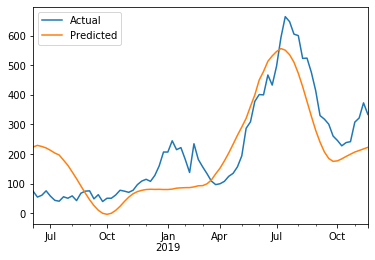

In [47]:
max_lookback = 45
model = load_model("models/16 Pass.h5")
df3 = pd.DataFrame(pred_test,index = test.index,
                  columns = ["xgb"])
df3 = pd.concat([test,df3],axis = 1)
cols = df3.columns.to_list()
cols = [cols[-1]] + cols[:-1]
df3 = df3[cols]
df3.index = pd.to_datetime(df3.index)
df2 = pd.concat([df2,df3],axis = 0, sort = True)
df2 = df2[cols]
input_len = max_lookback - 8
inputs = df2.iloc[len(df2) - len(test) - input_len:]
inputs = sc2.transform(inputs)
X_test = []
for i in range(len(inputs) - input_len):
    X_test.append(inputs[i:i+input_len,:-1])
X_test= np.array(X_test)
pred = model.predict(X_test)
actual = test["dengue"].values
pred = np.concatenate([np.zeros((pred.shape[0],3)),pred],axis = 1)
results  = sc2.inverse_transform(pred)
error = actual - results[:,-1]
vis = pd.DataFrame([actual,results[:,-1]])
vis = vis.T
vis.columns = ["Actual","Predicted"]
vis.index = test.index
vis.index = pd.to_datetime(vis.index)
vis.plot()
print(np.square(error).mean())

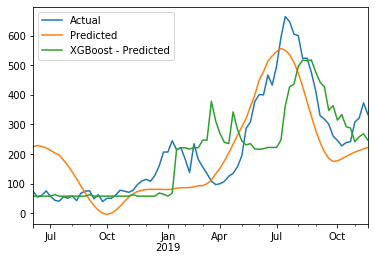

In [62]:
vis = pd.DataFrame([actual,results[:,-1],pred_test])
vis = vis.T
vis.columns = ["Actual","Predicted","XGBoost - Predicted"]
vis.index = test.index
vis.index = pd.to_datetime(vis.index)
vis.plot()
plt.savefig("stacked.png")